In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import yfinance as yf
from pandas_datareader import data as pdr
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

class SectorETFAnalyzer:
    def __init__(self, etf):
        """
        Inicializar el analizador con los ETFs e indicadores a analizar
        """
        self.etf_tickers = [
            etf
        ]
        
        self.indicators = [
            'JHDUSRGDPBR', 'T10Y3M', 'BAMLC0A0CM', 'BAMLH0A0HYM2',
            'BAMLHE00EHYIOAS', 'UMCSENT', 'UNRATE', 'GDPC1', 'DCOILWTICO',
            'CORESTICKM159SFRBATL', 'USSLIND', 'VIXCLS', 'ICSA',
            'MARTSMPCSM44000USS', 'RSXFS', 'TREAST', 'DGS1', 
            ##########################
            "TOTBKCR","BUSLOANS","WPU08", "PCOTTINDUSDM", "PWHEAMTUSDM", "PMAIZMTUSDM", "PCOFFOTMUSDM", "PCU2122212122210", "GVZCLS", 
            "PNRGINDEXM", "PCOPPUSDM", "PNGASEUUSDM", "PALLFNFINDEXQ", "BUSINV", "CP", "PCU33443344", 
            "CPIAUCSL", "M2SL", "SPPOPDPNDOLUSA", "HOUST", "CUSR0000SERA02"
        ]

        self.indicator_names = ['recession', 'yield_curve', 'corp_oas', 'hy_oas','eu_hy_oas', 'sentiment','empleo','real_gdp','oil',
                'inflacion','leading',
                'vix','weekjobclaims','retail_sales_percent','retail_sales','us_asset_balance','1y_yield', 
                #####################
                "tot_bank_credit", "commercial_industrial_loans","lumber", "cotton", "wheat", "corn", "coffee", "producer_gold", "gold_volatility", 
                "energy_price", "copper", "natural_gas", "all_commodities", "business_inventory", "corporate_profits", "semiconductor_electronics_manufacturing",
                "consumer_price_index", "M2_money_supply", "10y_real_interest_rate",  "new_homes", "streaming_media_consumption"
                ]
        
        self.cycle_dates = [
            ('2001-11-01', '2007-12-01'),
            ('2007-12-01', '2009-06-01'),
            ('2009-06-01', '2010-06-01'),
            ('2020-02-01', '2020-04-01'),
            ('2020-04-01', '2024-12-10'),
        ]
    
    def resample_to_weekly(self, df, method='last'):
        """
        Convertir datos a frecuencia semanal
        method: 'last' para precios, 'mean' para otros indicadores
        """
        if method == 'last':
            return df.resample('W-FRI').last()
        else:
            return df.resample('W-FRI').mean()
    
    def get_economic_data(self, start_date, end_date):
        """
        Obtener datos económicos usando pandas_datareader y convertir a semanal
        """
        # Ajustar fechas para compensar la frecuencia mensual
        adjusted_start = (pd.to_datetime(start_date) - pd.DateOffset(months=2)).strftime('%Y-%m-%d')
        adjusted_end = (pd.to_datetime(end_date) + pd.DateOffset(months=2)).strftime('%Y-%m-%d')
        
        data = pd.DataFrame()
        
        for indicator in self.indicators:
            try:
                series = pdr.DataReader(indicator, 'fred', adjusted_start, adjusted_end)
                # Convertir a semanal usando forward fill para datos mensuales
                weekly_series = series.asfreq('W-FRI', method='ffill')
                data[indicator] = weekly_series
            except Exception as e:
                print(f"Error obteniendo {indicator}: {e}")
                
        return data.fillna(method='ffill')
    
    def get_etf_data(self, start_date, end_date):
        """
        Obtener datos de los ETFs usando yfinance y convertir a semanal
        """
        # Ajustar fechas para obtener datos suficientes
        adjusted_start = (pd.to_datetime(start_date) - pd.DateOffset(weeks=1)).strftime('%Y-%m-%d')
        adjusted_end = (pd.to_datetime(end_date) + pd.DateOffset(weeks=1)).strftime('%Y-%m-%d')
        
        etf_data = pd.DataFrame()
        
        for ticker in self.etf_tickers:
            try:
                etf = yf.download(ticker, start=adjusted_start, end=adjusted_end)
                weekly_prices = self.resample_to_weekly(etf['Adj Close'], method='last')
                etf_data[ticker] = weekly_prices
            except Exception as e:
                print(f"Error obteniendo {ticker}: {e}")
                
        # Asegurar que no hay NaN al principio o final de las series
        etf_data = etf_data.dropna(how='all')
                
        return etf_data
    
    def calculate_returns(self, prices):
        """
        Calcular retornos logarítmicos semanales
        """
        return np.log(prices / prices.shift(1))
    
    def analyze_cycle(self, economic_data, etf_data, start_date, end_date):
        """
        Analizar un ciclo específico
        """
        # Alinear índices antes de filtrar
        all_data = pd.concat([economic_data, etf_data], axis=1)
        all_data = all_data.dropna(how='all')  # Eliminar filas donde no hay datos
        
        # Filtrar datos para el ciclo
        mask = (all_data.index >= pd.to_datetime(start_date, format='%Y-%m-%d')) & (all_data.index <= pd.to_datetime(end_date, format='%Y-%m-%d'))
        cycle_data = all_data[mask]
        
        # Separar datos económicos y ETFs
        cycle_economic = cycle_data[self.indicators]
        cycle_etf = cycle_data[self.etf_tickers]
        
        # Calcular retornos semanales
        etf_returns = self.calculate_returns(cycle_etf)
        
        results = {}
        
        for etf_ticker in self.etf_tickers:
            correlations = {}
            impact_scores = {}
            
            for indicator, name in zip(self.indicators, self.indicator_names)   :
                if cycle_economic[indicator].std() > 0 and not etf_returns[etf_ticker].isna().all():
                    # Alinear datos semanales
                    aligned_data = pd.concat([
                        cycle_economic[indicator],
                        etf_returns[etf_ticker]
                    ], axis=1).dropna()
                    
                    if len(aligned_data) > 1:
                        # Correlación
                        corr = aligned_data.iloc[:, 0].corr(aligned_data.iloc[:, 1])
                        correlations[name] = corr
                        
                        # Impacto
                        X = aligned_data.iloc[:, 0].values.reshape(-1, 1)
                        y = aligned_data.iloc[:, 1].values
                        
                        scaler_X = StandardScaler()
                        scaler_y = StandardScaler()
                        X_scaled = scaler_X.fit_transform(X)
                        y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()
                        
                        impact = np.abs(np.cov(X_scaled.ravel(), y_scaled)[0,1])
                        impact_scores[name] = impact
            
            results[etf_ticker] = {
                'correlations': correlations,
                'impact_scores': impact_scores,
                'n_observations': len(aligned_data)  # Añadir número de observaciones
            }
            
        return results
    
    def plot_cycle_results(self, results, cycle_period, save_path=None):
        """
        Visualizar los resultados del análisis para un ciclo
        """
        n_etfs = len(self.etf_tickers)
        fig, axes = plt.subplots(n_etfs, 1, figsize=(15, 6*n_etfs))
        fig.suptitle(f'Análisis de Indicadores para Ciclo {cycle_period}\nDatos Semanales', size=16)
        
        for idx, etf in enumerate(self.etf_tickers):
            etf_results = results[etf]
            
            # Crear DataFrame combinado
            df_plot = pd.DataFrame({
                'Impacto': pd.Series(etf_results['impact_scores']),
                'Correlación': pd.Series(etf_results['correlations'])
            })
            
            # Ordenar por impacto
            df_plot = df_plot.sort_values('Impacto', ascending=True)
            
            # Graficar
            ax = axes[idx] if n_etfs > 1 else axes
            df_plot['Impacto'].plot(kind='barh', ax=ax, color='skyblue', alpha=0.6)
            ax2 = ax.twiny()
            df_plot['Correlación'].plot(kind='barh', ax=ax2, color='red', alpha=0.3)
            
            ax.set_title(f'ETF: {etf} (n={etf_results["n_observations"]} semanas)')
            ax.set_xlabel('Impacto (Azul)')
            ax2.set_xlabel('Correlación (Rojo)')
            
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        
        return fig
    
    def run_analysis(self):
        """
        Ejecutar el análisis completo
        """
        # Determinar fechas globales
        start_date = min(datetime.strptime(dates[0], '%Y-%m-%d') 
                        for dates in self.cycle_dates)
        end_date = max(datetime.strptime(dates[1], '%Y-%m-%d') 
                      for dates in self.cycle_dates)
        
        # Obtener datos
        economic_data = self.get_economic_data(start_date, end_date)
        etf_data = self.get_etf_data(start_date, end_date)
        
        # Analizar cada ciclo
        cycle_results = {}
        for start, end in self.cycle_dates:
            cycle_results[f"{start}-{end}"] = self.analyze_cycle(
                economic_data, 
                etf_data, 
                start, 
                end
            )
        
        return cycle_results
    
    def generate_summary(self, cycle_results):
        """
        Generar resumen de los resultados
        """
        summary = pd.DataFrame()
        
        for cycle, results in cycle_results.items():
            cycle_summary = []
            
            for etf in self.etf_tickers:
                etf_data = results[etf]
                
                # Encontrar el indicador con mayor impacto
                top_impact = max(etf_data['impact_scores'].items(), 
                               key=lambda x: x[1])
                
                # Encontrar el indicador con mayor correlación absoluta
                correlations = etf_data['correlations']
                top_corr = max(correlations.items(), 
                             key=lambda x: abs(x[1]))
                
                cycle_summary.append({
                    'ETF': etf,
                    'Top_Indicator_Impact': top_impact[0],
                    'Impact_Score': top_impact[1],
                    'Top_Indicator_Corr': top_corr[0],
                    'Correlation': top_corr[1],
                    'N_Weeks': etf_data['n_observations']
                })
            
            cycle_df = pd.DataFrame(cycle_summary)
            cycle_df['Cycle'] = cycle
            summary = pd.concat([summary, cycle_df])
        
        return summary.reset_index(drop=True)

# Ejemplo de uso:
"""
# Inicializar el analizador
analyzer = SectorETFAnalyzer()

# Ejecutar análisis
results = analyzer.run_analysis()

# Generar y mostrar resumen
summary = analyzer.generate_summary(results)
print("\nResumen del análisis:")
print(summary)

# Generar gráficos para cada ciclo
for cycle in results.keys():
    fig = analyzer.plot_cycle_results(
        results[cycle], 
        cycle,
        save_path=f'analisis_ciclo_{cycle.replace("/", "-")}.png'
    )
    plt.close(fig)
"""

'\n# Inicializar el analizador\nanalyzer = SectorETFAnalyzer()\n\n# Ejecutar análisis\nresults = analyzer.run_analysis()\n\n# Generar y mostrar resumen\nsummary = analyzer.generate_summary(results)\nprint("\nResumen del análisis:")\nprint(summary)\n\n# Generar gráficos para cada ciclo\nfor cycle in results.keys():\n    fig = analyzer.plot_cycle_results(\n        results[cycle], \n        cycle,\n        save_path=f\'analisis_ciclo_{cycle.replace("/", "-")}.png\'\n    )\n    plt.close(fig)\n'

/tmp/ipykernel_170894/1113042025.py:76: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return data.fillna(method='ffill')
[*********************100%***********************]  1 of 1 completed
/home/muniia/Documents/TFM/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/muniia/Documents/TFM/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Resumen del análisis:
   ETF Top_Indicator_Impact  Impact_Score Top_Indicator_Corr  Correlation  \
0  XLE                  vix      0.201785                vix    -0.201149   
1  XLE          natural_gas      0.215883        natural_gas    -0.213079   
2  XLE                  vix      0.486072                vix    -0.476541   
3  XLE        weekjobclaims      0.729806      weekjobclaims     0.625548   
4  XLE        weekjobclaims      0.126005      weekjobclaims     0.125399   

   N_Weeks                  Cycle  
0      317  2001-11-01-2007-12-01  
1       77  2007-12-01-2009-06-01  
2       51  2009-06-01-2010-06-01  
3        7  2020-02-01-2020-04-01  
4      208  2020-04-01-2024-12-10  


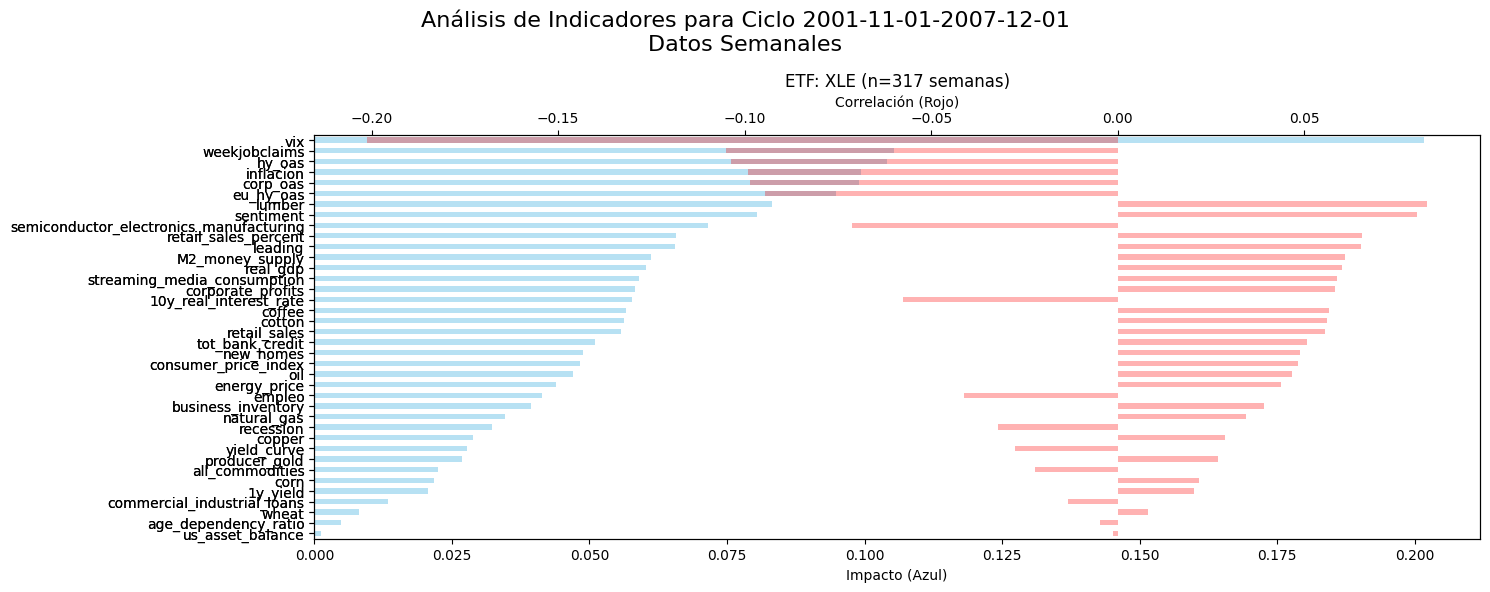

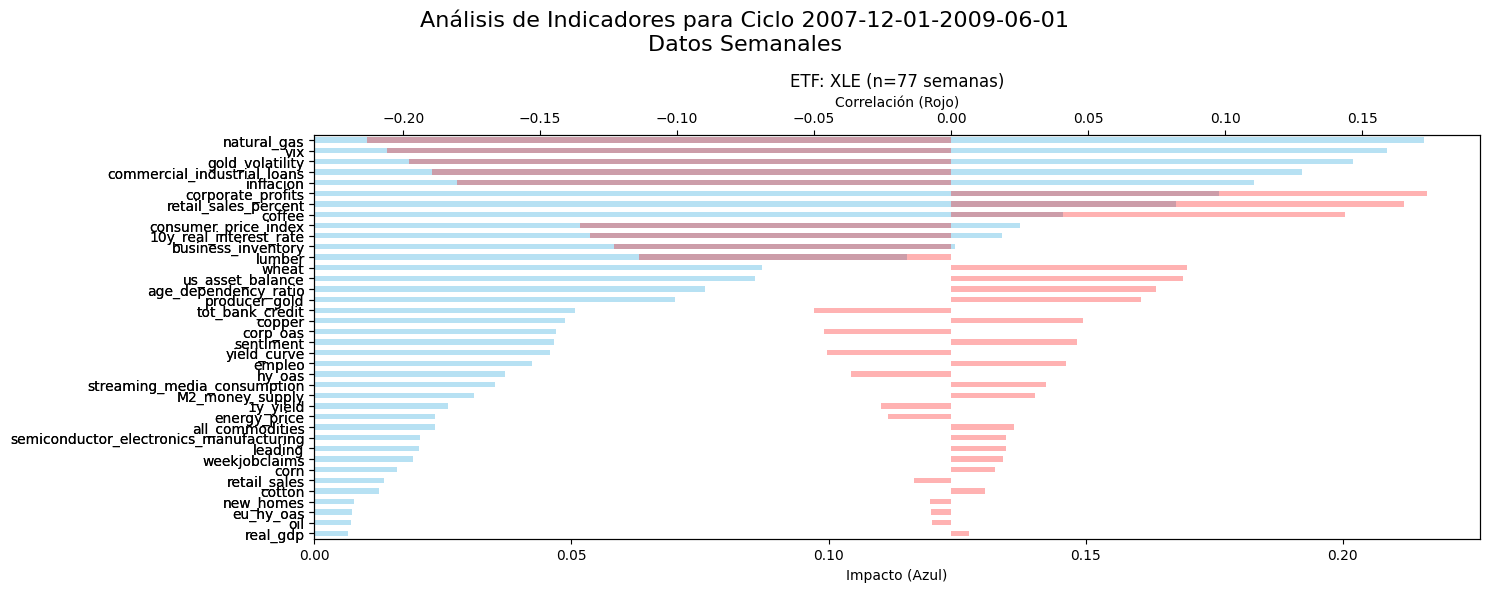

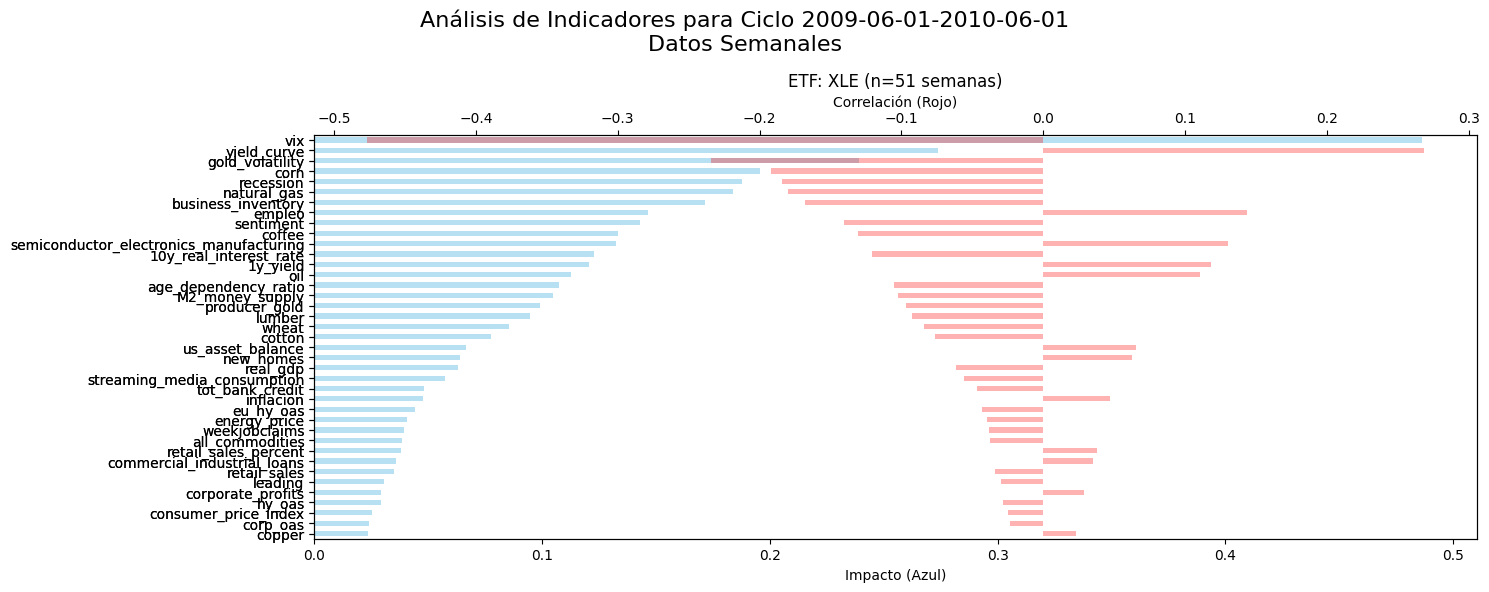

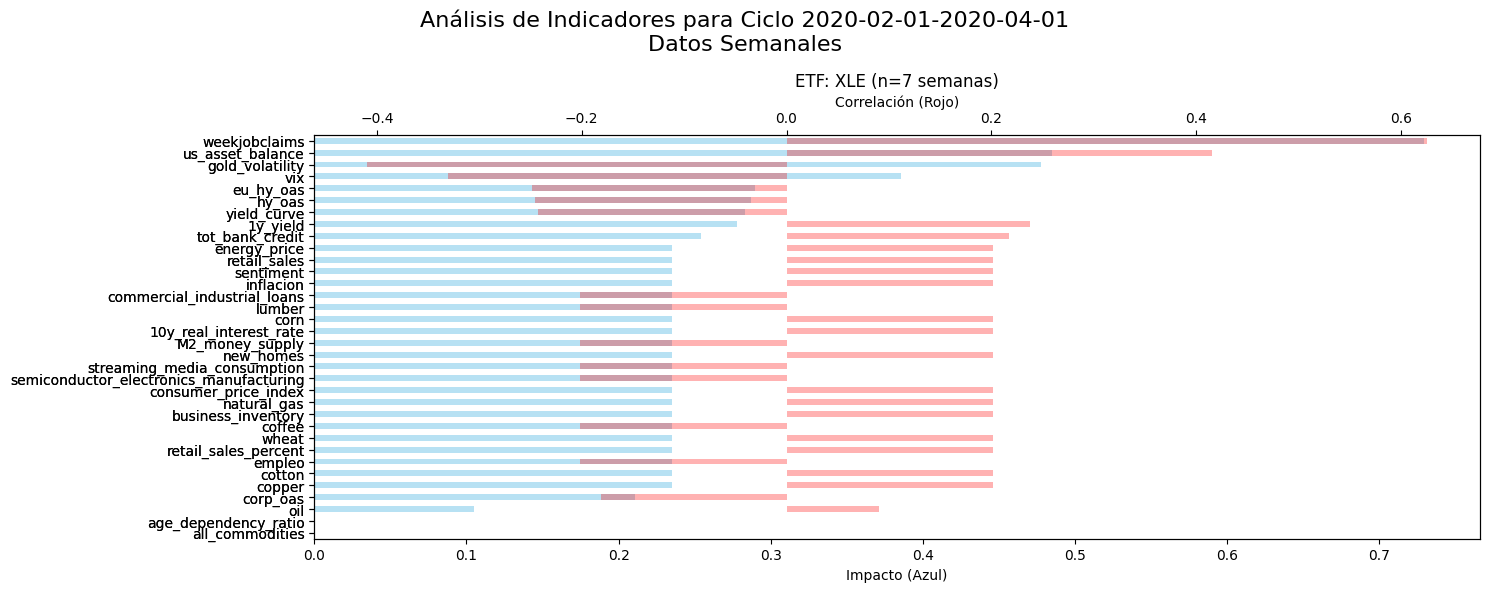

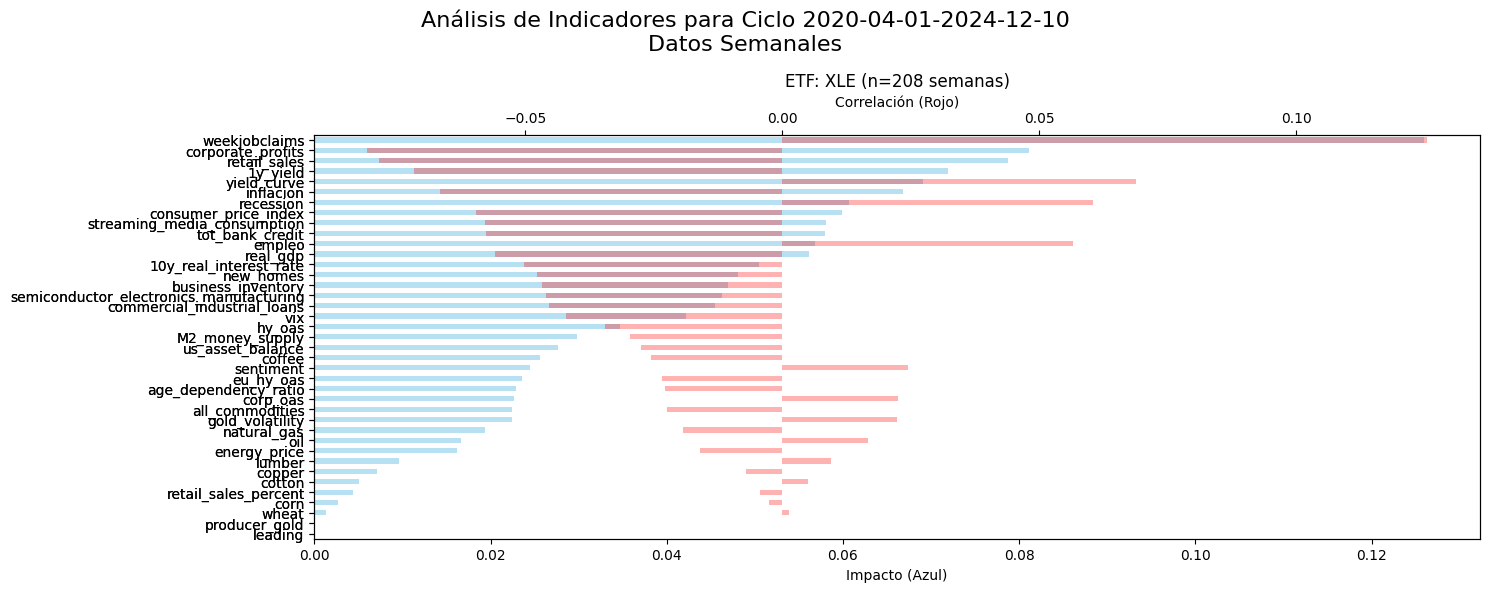

____________________________________________________________________________________________________


/tmp/ipykernel_170894/1113042025.py:76: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return data.fillna(method='ffill')
[*********************100%***********************]  1 of 1 completed
/home/muniia/Documents/TFM/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/muniia/Documents/TFM/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Resumen del análisis:
   ETF Top_Indicator_Impact  Impact_Score Top_Indicator_Corr  Correlation  \
0  XLB                  vix      0.212945                vix    -0.212273   
1  XLB      gold_volatility      0.291882    gold_volatility    -0.286269   
2  XLB                  vix      0.447621                vix    -0.438844   
3  XLB        weekjobclaims      0.730607      weekjobclaims     0.626235   
4  XLB        weekjobclaims      0.265115      weekjobclaims     0.263840   

   N_Weeks                  Cycle  
0      317  2001-11-01-2007-12-01  
1       77  2007-12-01-2009-06-01  
2       51  2009-06-01-2010-06-01  
3        7  2020-02-01-2020-04-01  
4      208  2020-04-01-2024-12-10  


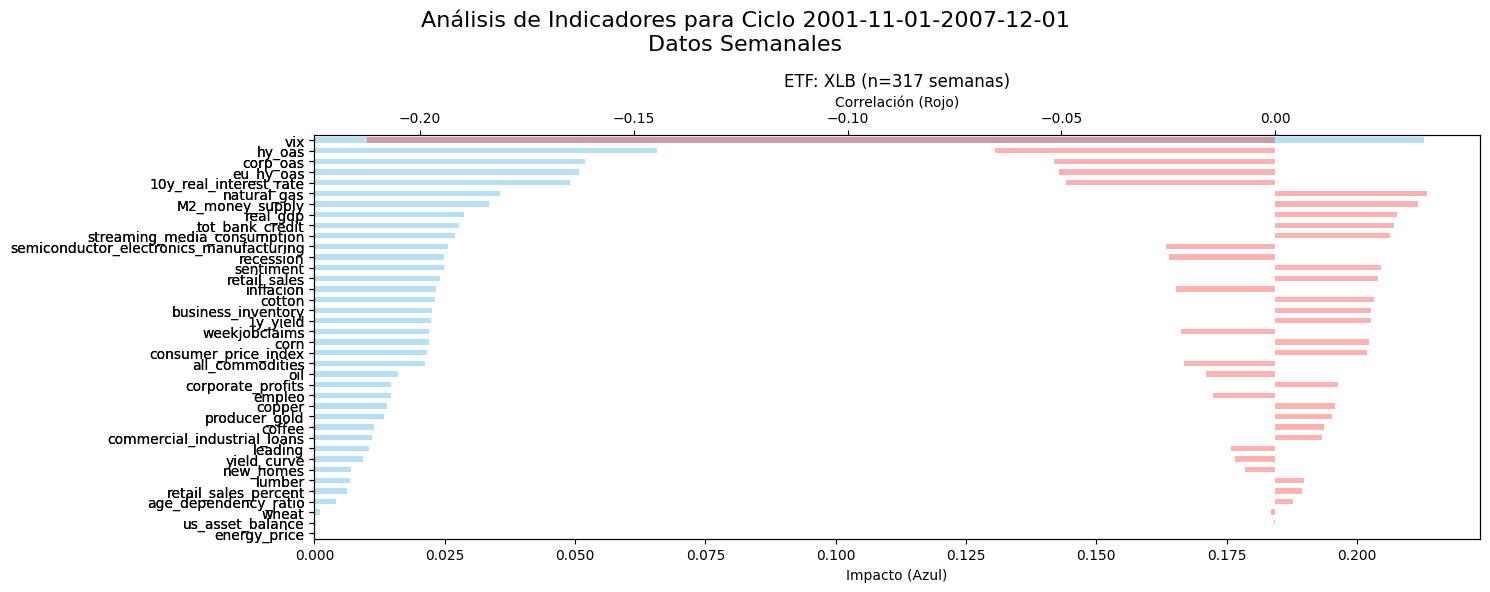

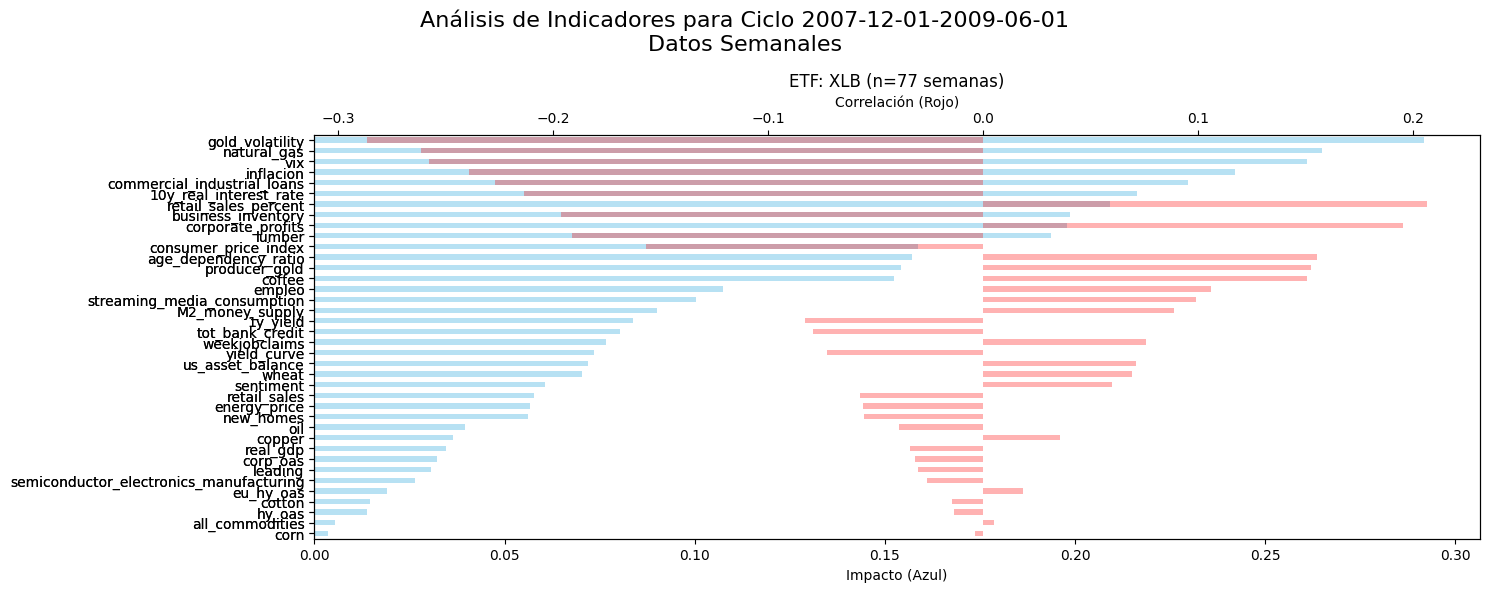

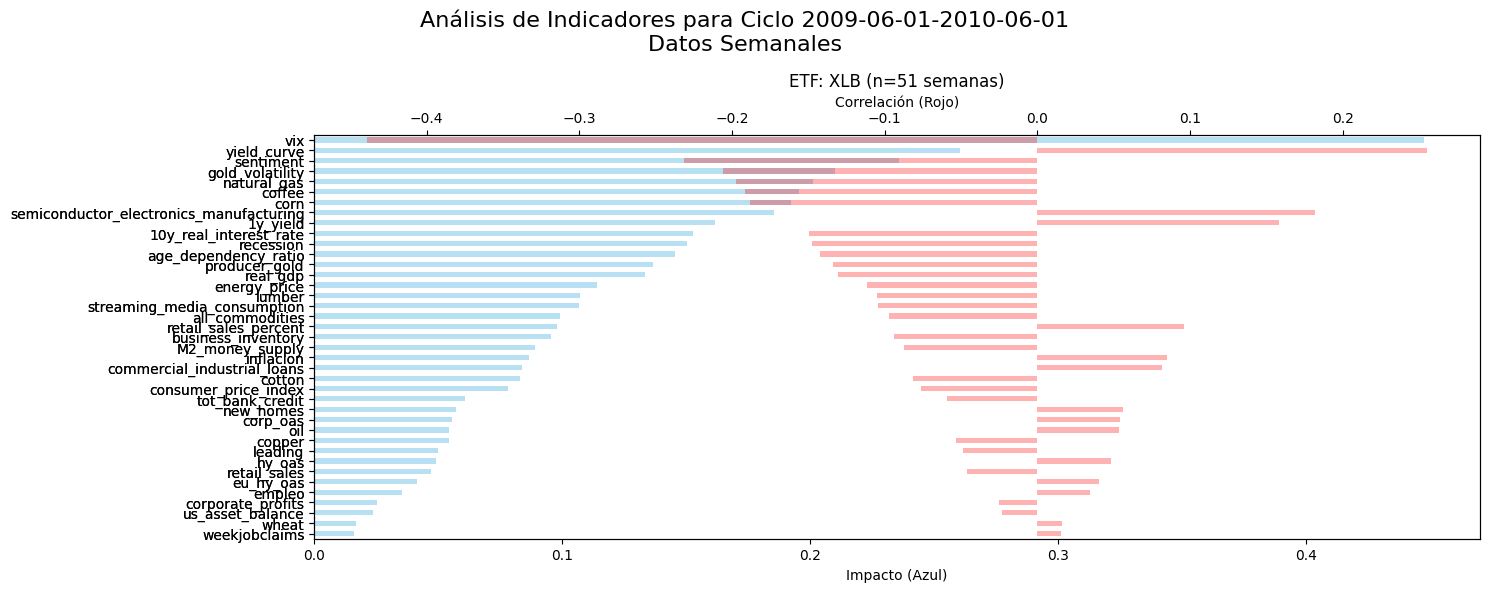

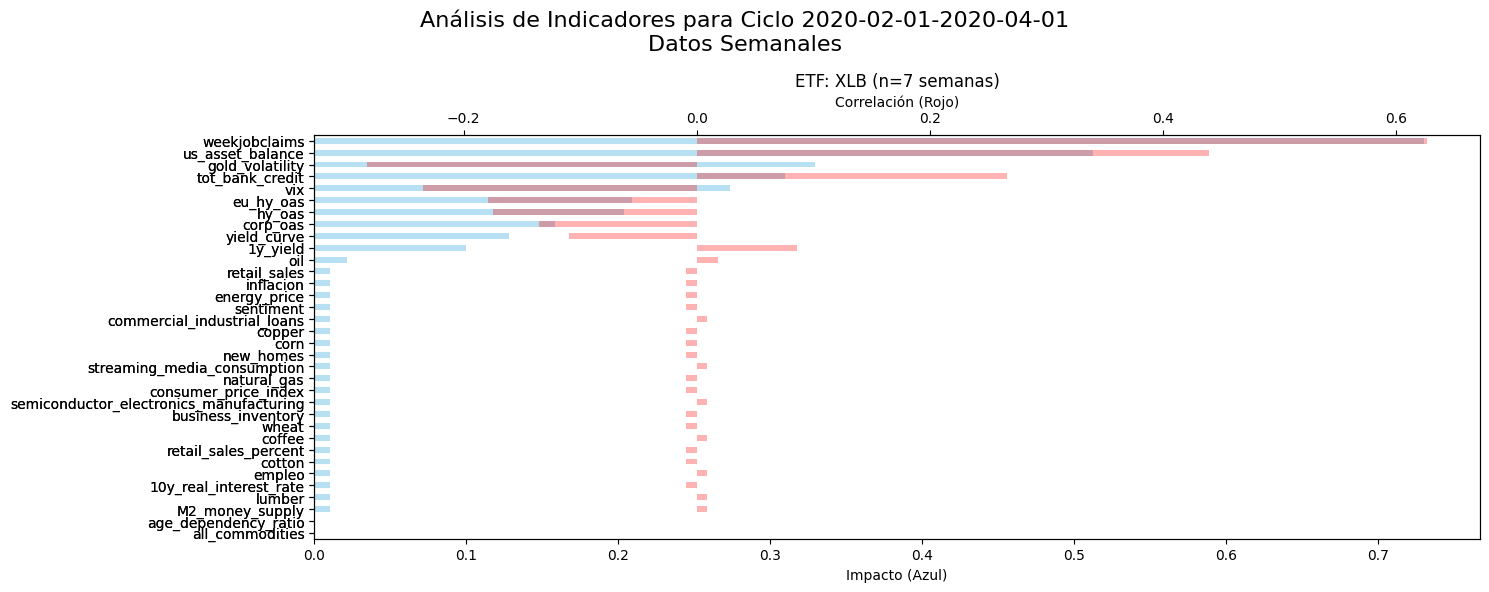

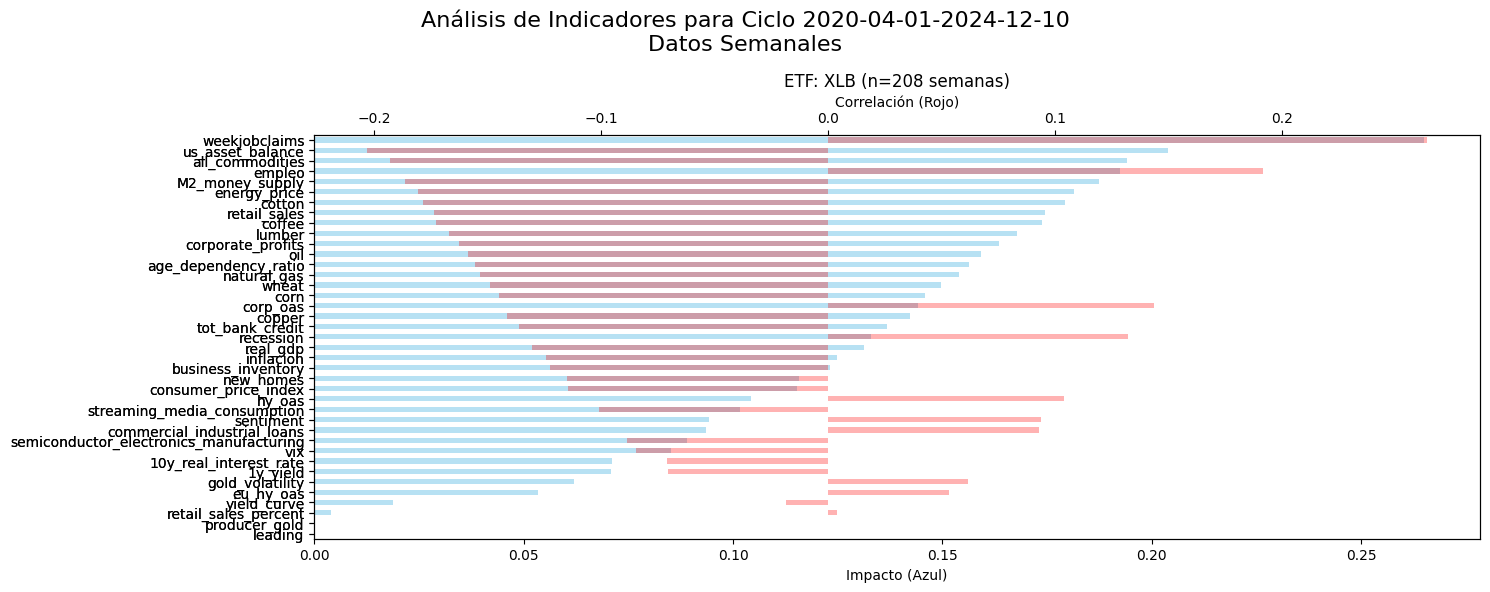

____________________________________________________________________________________________________


/tmp/ipykernel_170894/1113042025.py:76: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return data.fillna(method='ffill')
[*********************100%***********************]  1 of 1 completed
/home/muniia/Documents/TFM/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/muniia/Documents/TFM/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Resumen del análisis:
   ETF Top_Indicator_Impact  Impact_Score Top_Indicator_Corr  Correlation  \
0  XLI                  vix      0.208635                vix    -0.207977   
1  XLI      gold_volatility      0.246737    gold_volatility    -0.241992   
2  XLI                  vix      0.554266                vix    -0.543398   
3  XLI        weekjobclaims      0.829134      weekjobclaims     0.710686   
4  XLI               cotton      0.189113             cotton    -0.188203   

   N_Weeks                  Cycle  
0      317  2001-11-01-2007-12-01  
1       77  2007-12-01-2009-06-01  
2       51  2009-06-01-2010-06-01  
3        7  2020-02-01-2020-04-01  
4      208  2020-04-01-2024-12-10  


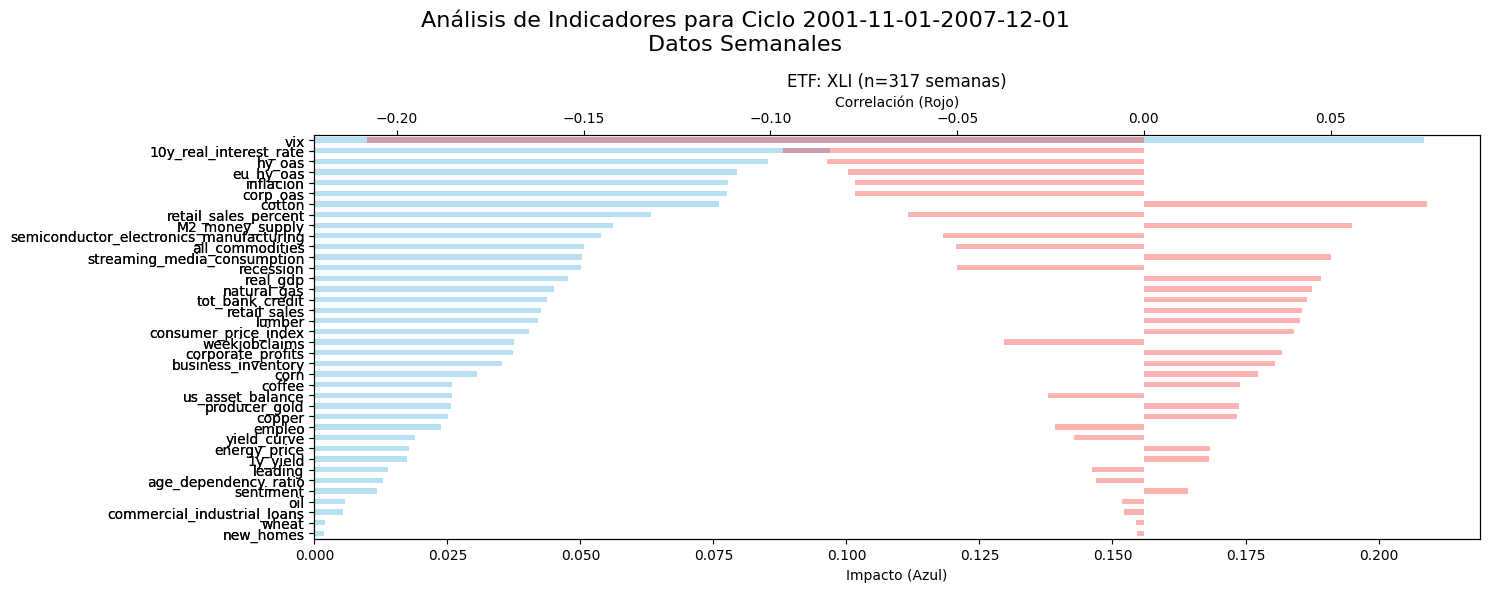

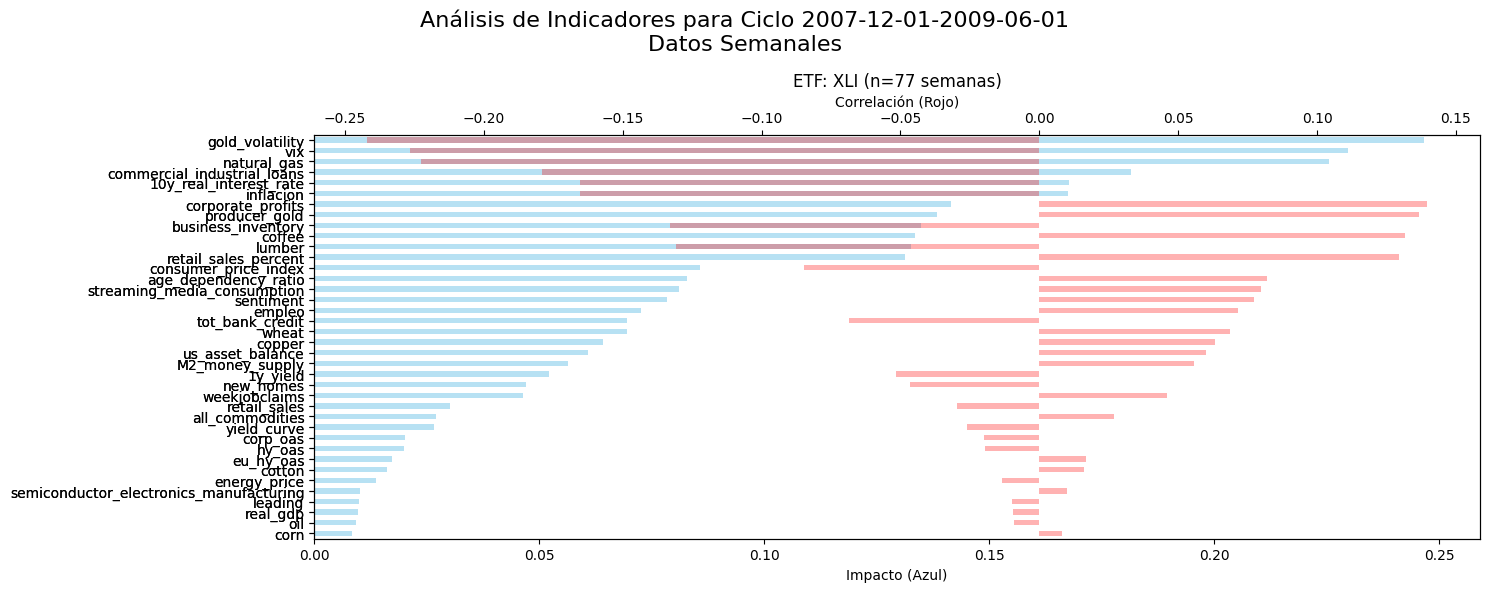

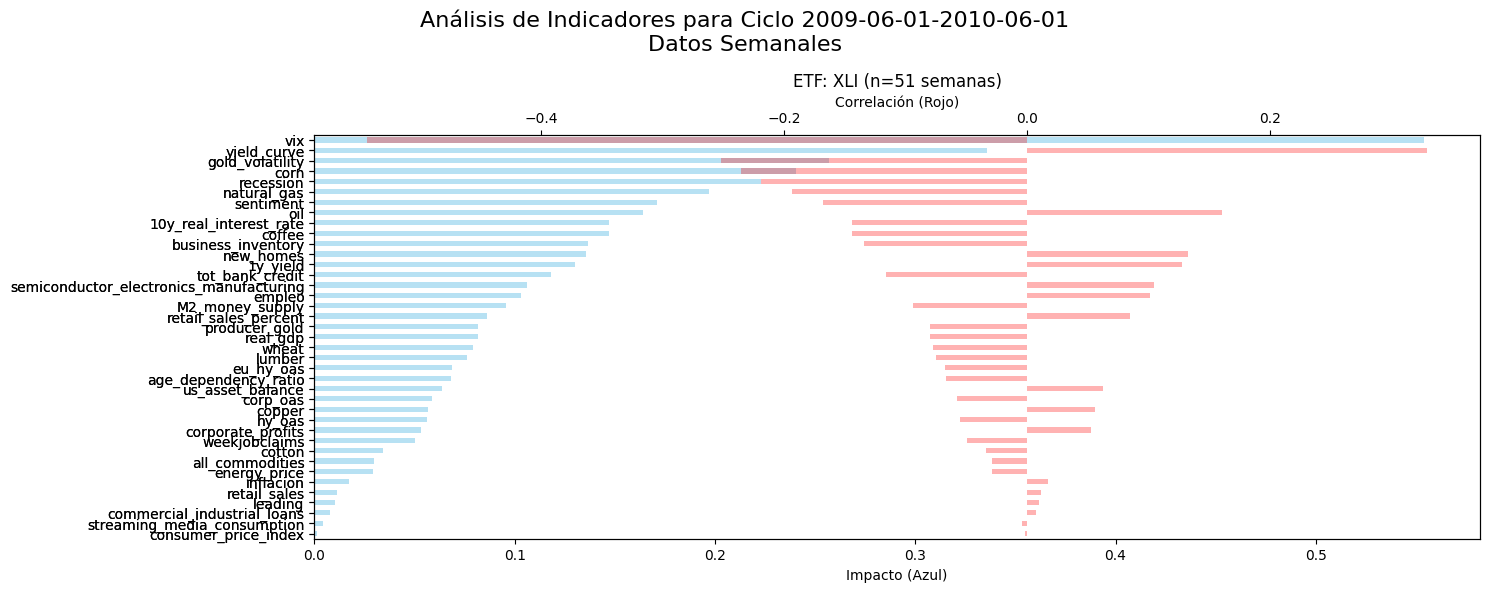

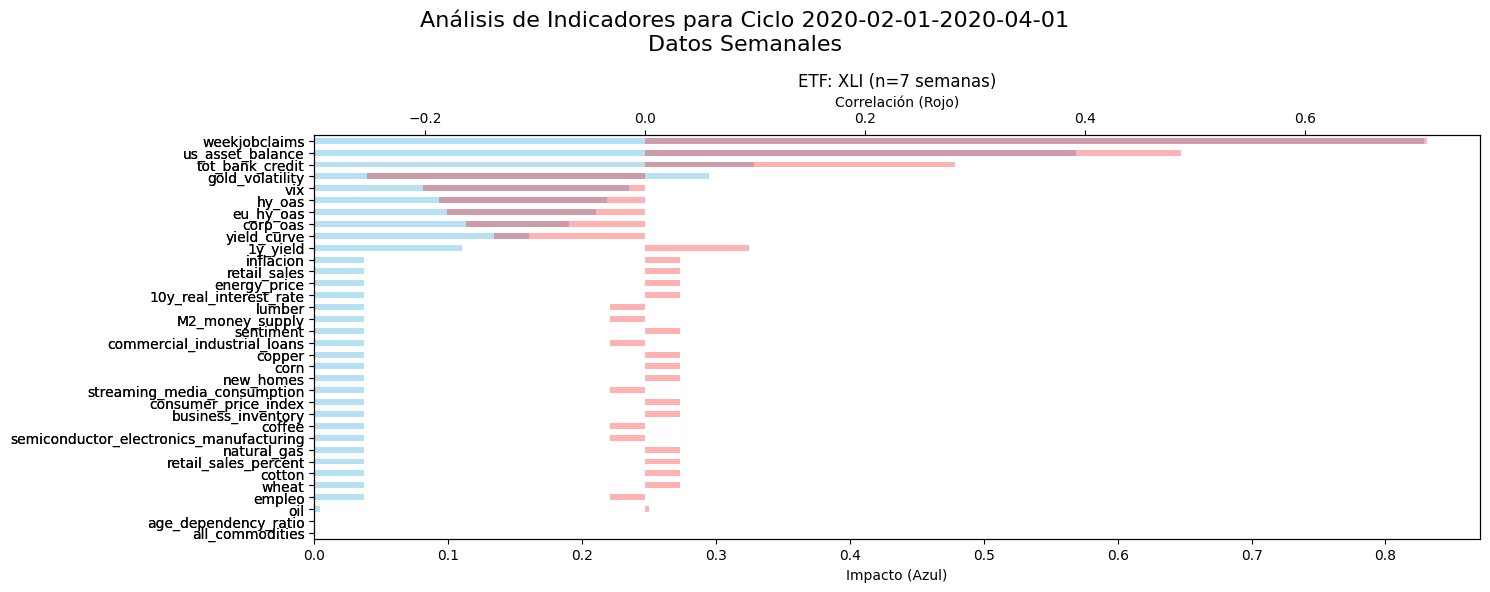

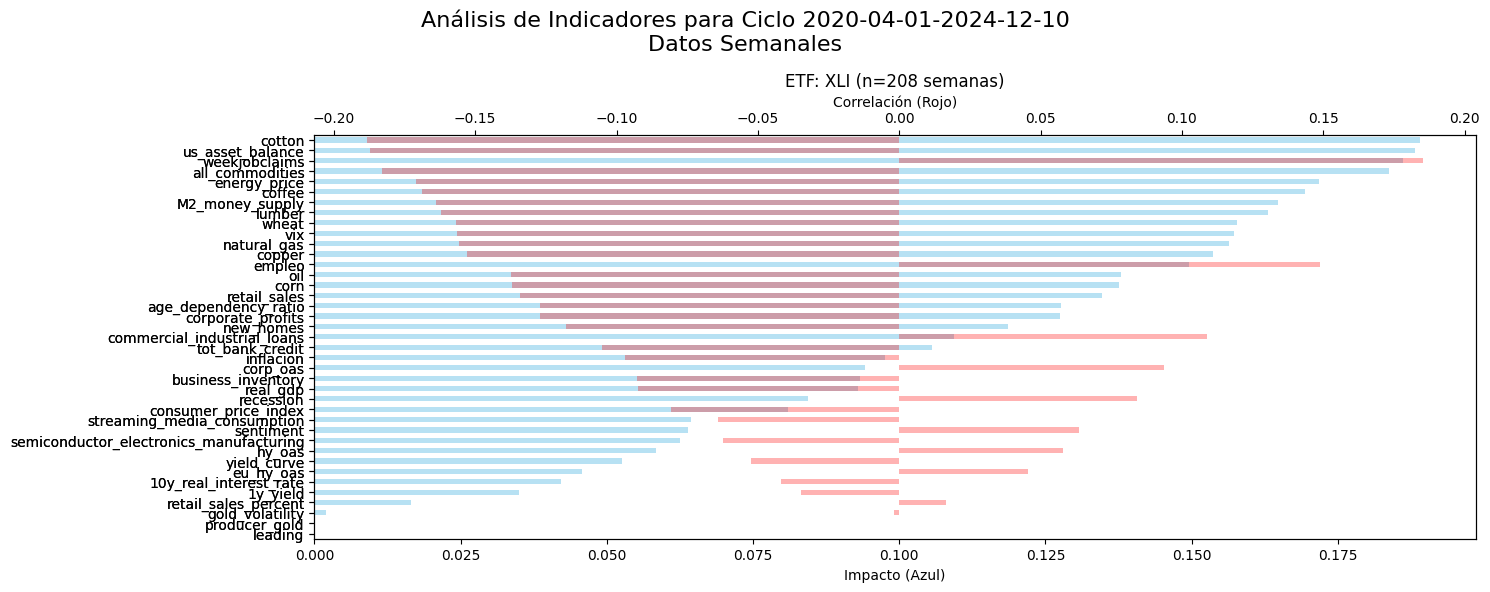

____________________________________________________________________________________________________


/tmp/ipykernel_170894/1113042025.py:76: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return data.fillna(method='ffill')
[*********************100%***********************]  1 of 1 completed
/home/muniia/Documents/TFM/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/muniia/Documents/TFM/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Resumen del análisis:
   ETF Top_Indicator_Impact  Impact_Score Top_Indicator_Corr  Correlation  \
0  XLK                  vix      0.162210                vix    -0.161698   
1  XLK      gold_volatility      0.232262    gold_volatility    -0.227795   
2  XLK                  vix      0.492711                vix    -0.483050   
3  XLK        weekjobclaims      0.758200      weekjobclaims     0.649886   
4  XLK               cotton      0.214782             cotton    -0.213749   

   N_Weeks                  Cycle  
0      317  2001-11-01-2007-12-01  
1       77  2007-12-01-2009-06-01  
2       51  2009-06-01-2010-06-01  
3        7  2020-02-01-2020-04-01  
4      208  2020-04-01-2024-12-10  


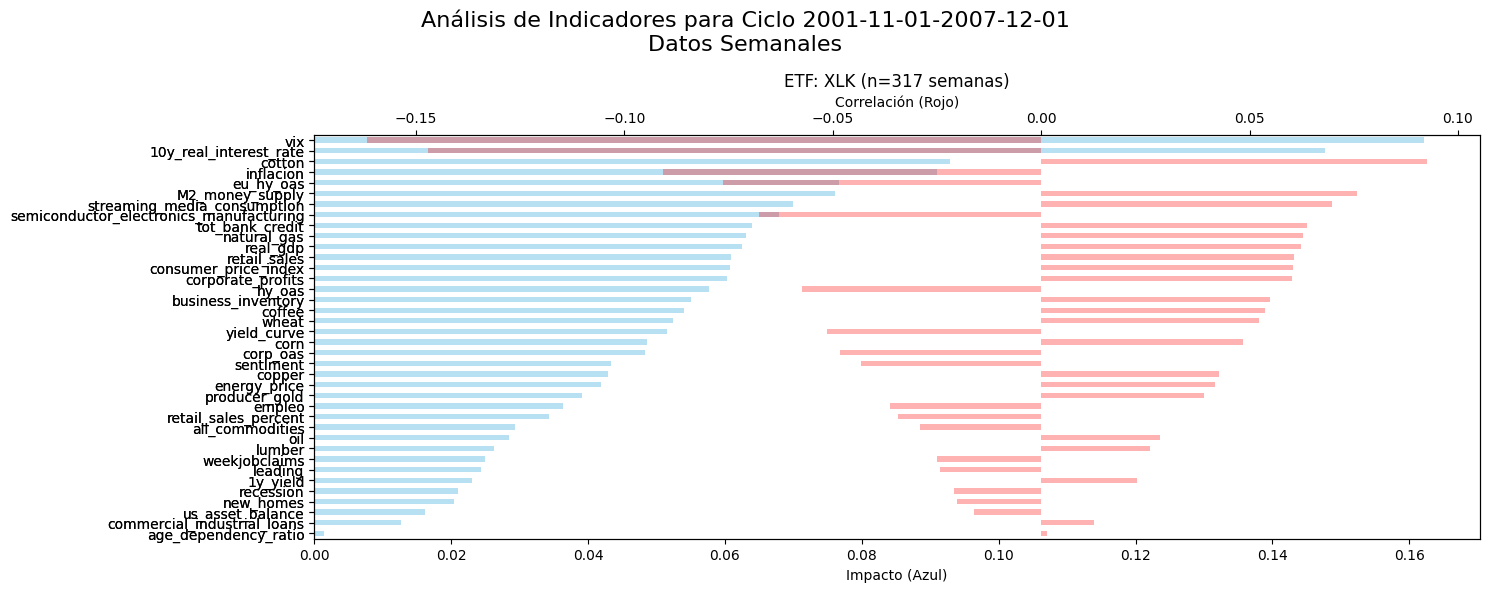

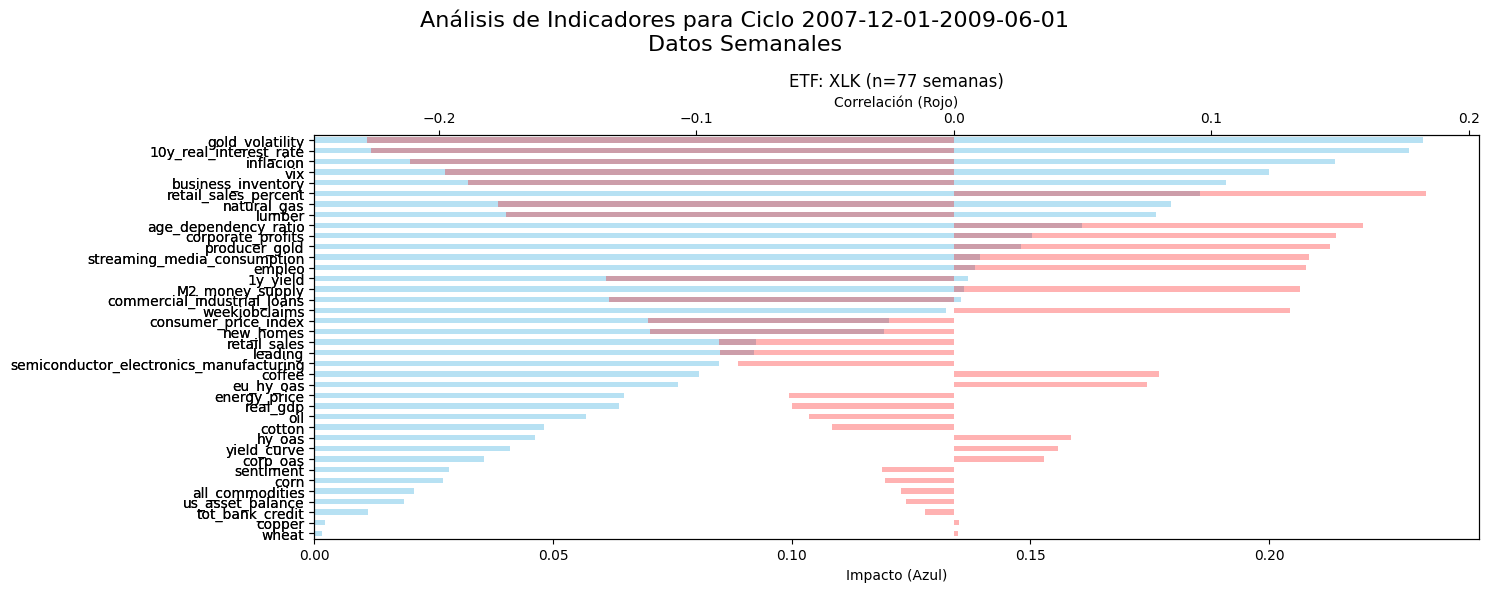

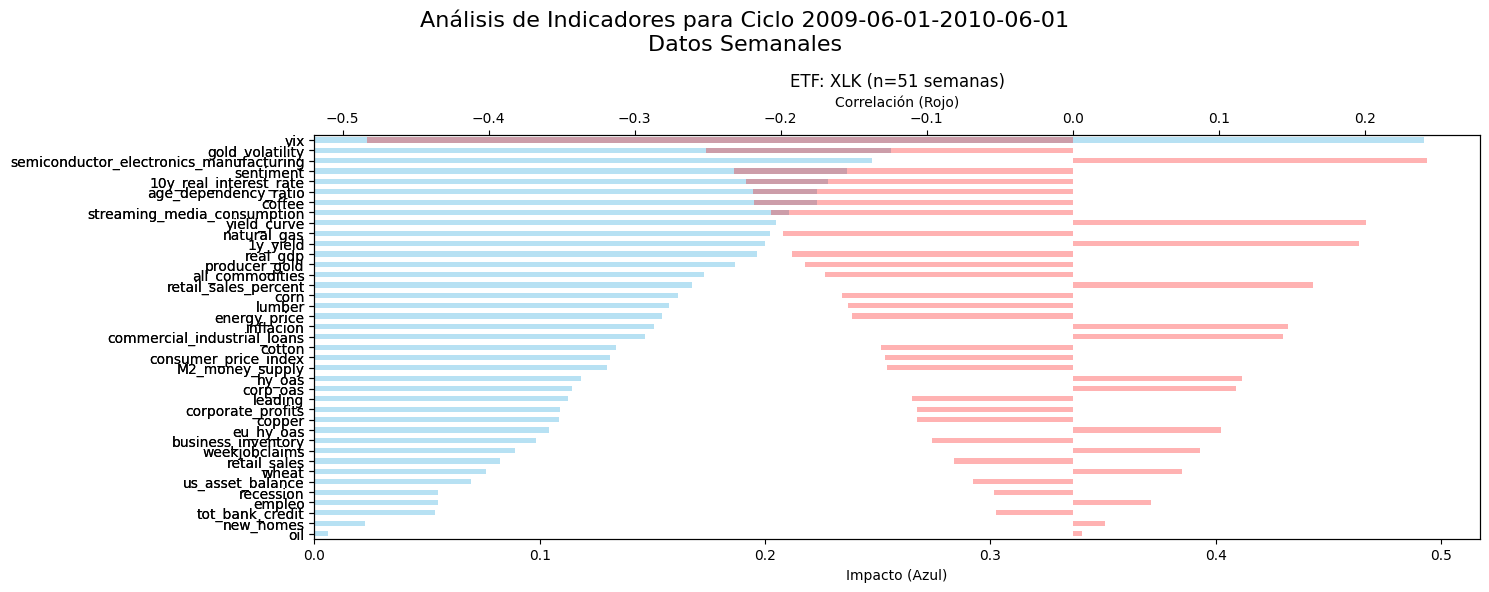

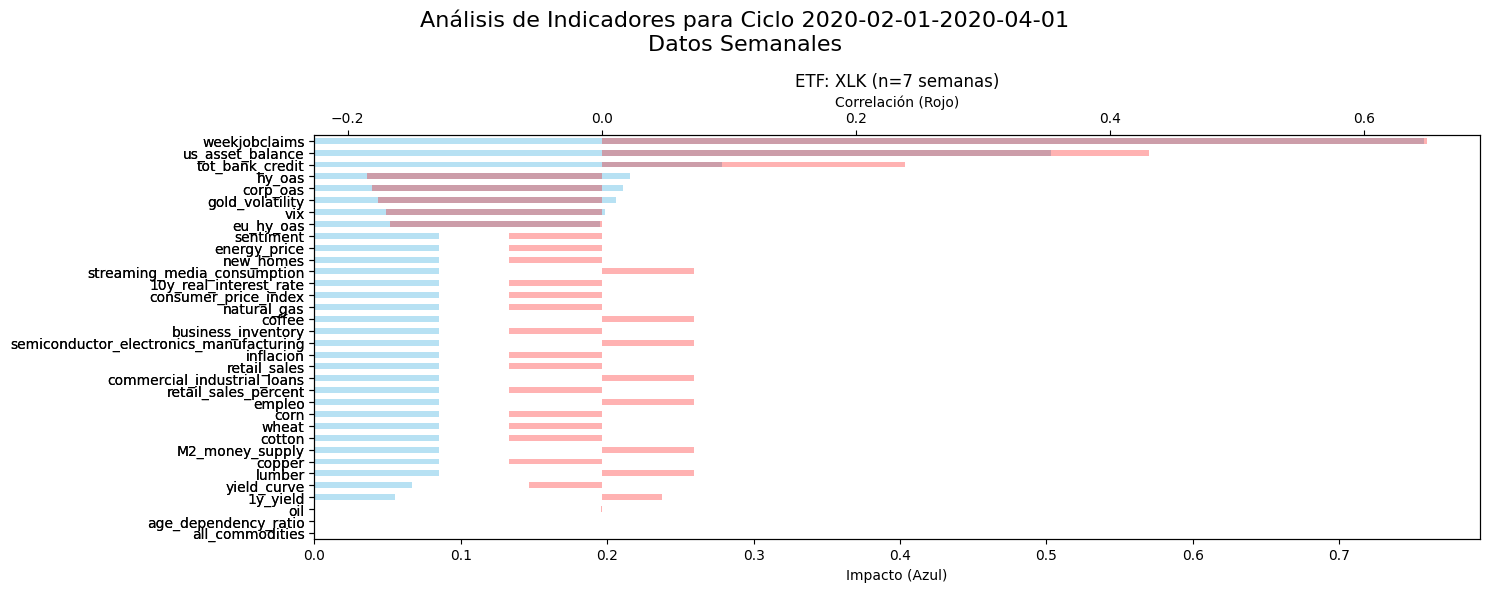

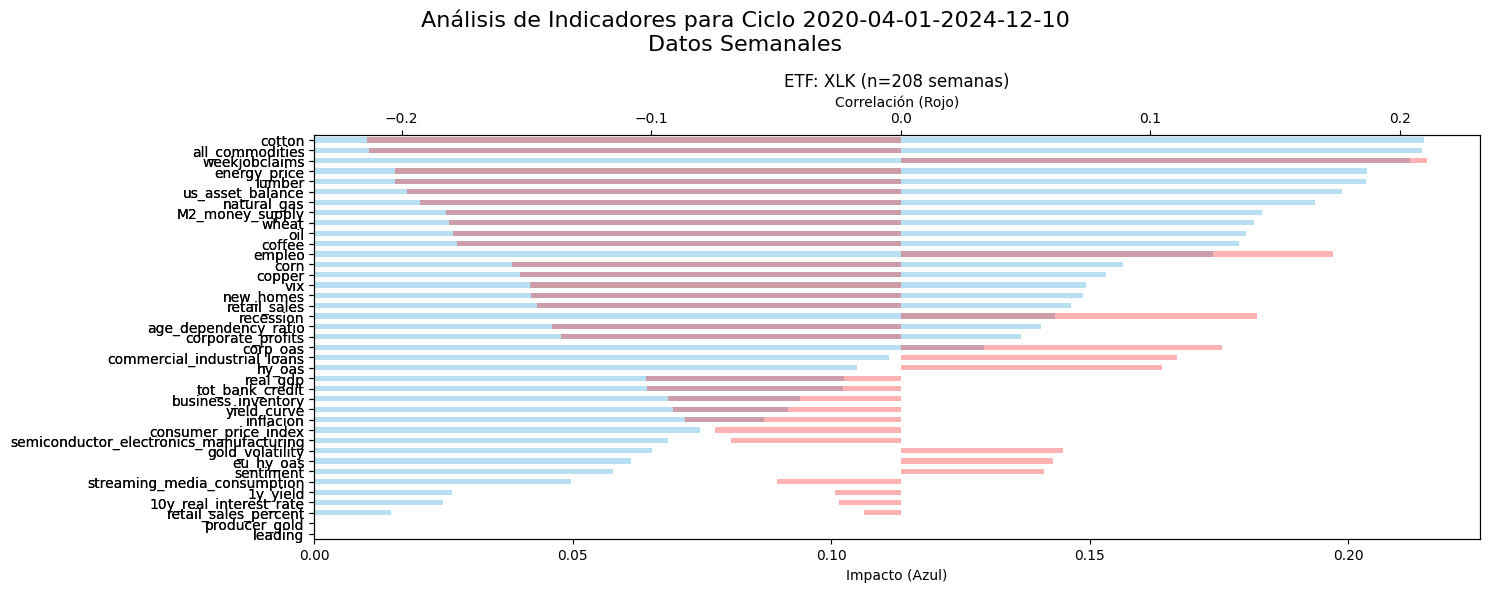

____________________________________________________________________________________________________


/tmp/ipykernel_170894/1113042025.py:76: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return data.fillna(method='ffill')
[*********************100%***********************]  1 of 1 completed
/home/muniia/Documents/TFM/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/muniia/Documents/TFM/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Resumen del análisis:
   ETF Top_Indicator_Impact  Impact_Score Top_Indicator_Corr  Correlation  \
0  XLF                  vix      0.161664                vix    -0.161154   
1  XLF      gold_volatility      0.232696    gold_volatility    -0.228221   
2  XLF                  vix      0.461689                vix    -0.452636   
3  XLF        weekjobclaims      0.810816      weekjobclaims     0.694985   
4  XLF        weekjobclaims      0.181119      weekjobclaims     0.180248   

   N_Weeks                  Cycle  
0      317  2001-11-01-2007-12-01  
1       77  2007-12-01-2009-06-01  
2       51  2009-06-01-2010-06-01  
3        7  2020-02-01-2020-04-01  
4      208  2020-04-01-2024-12-10  


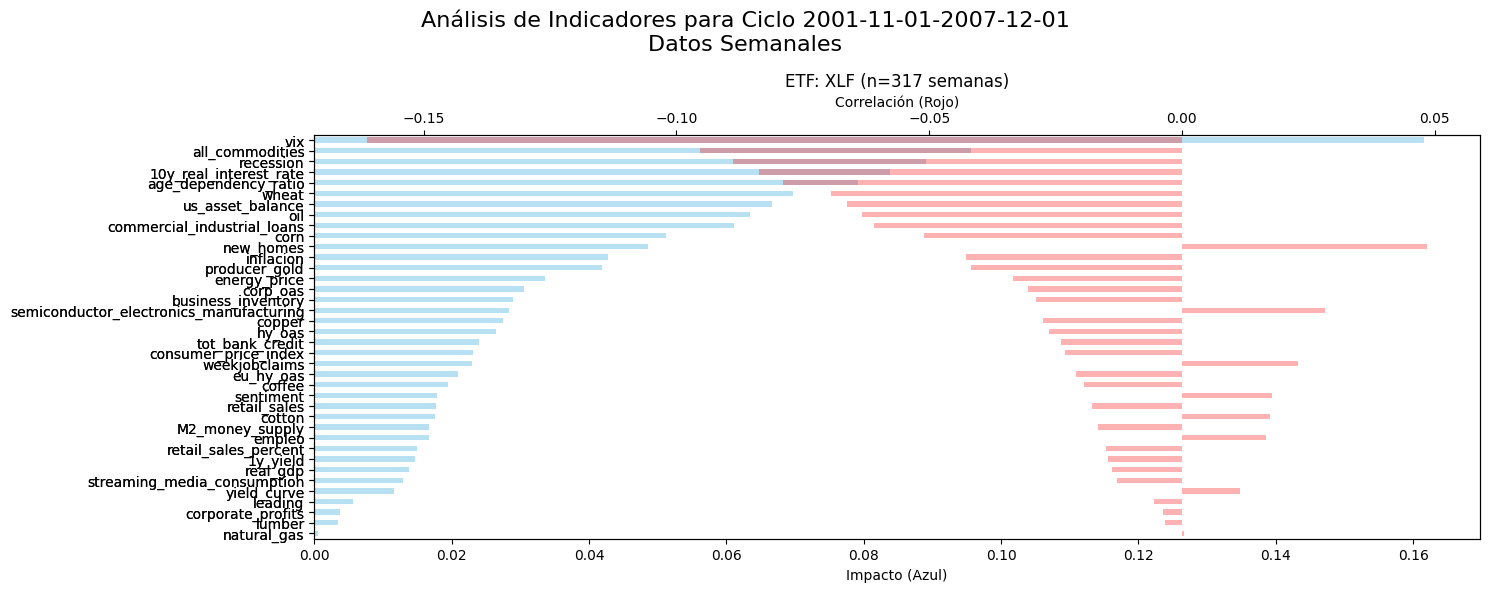

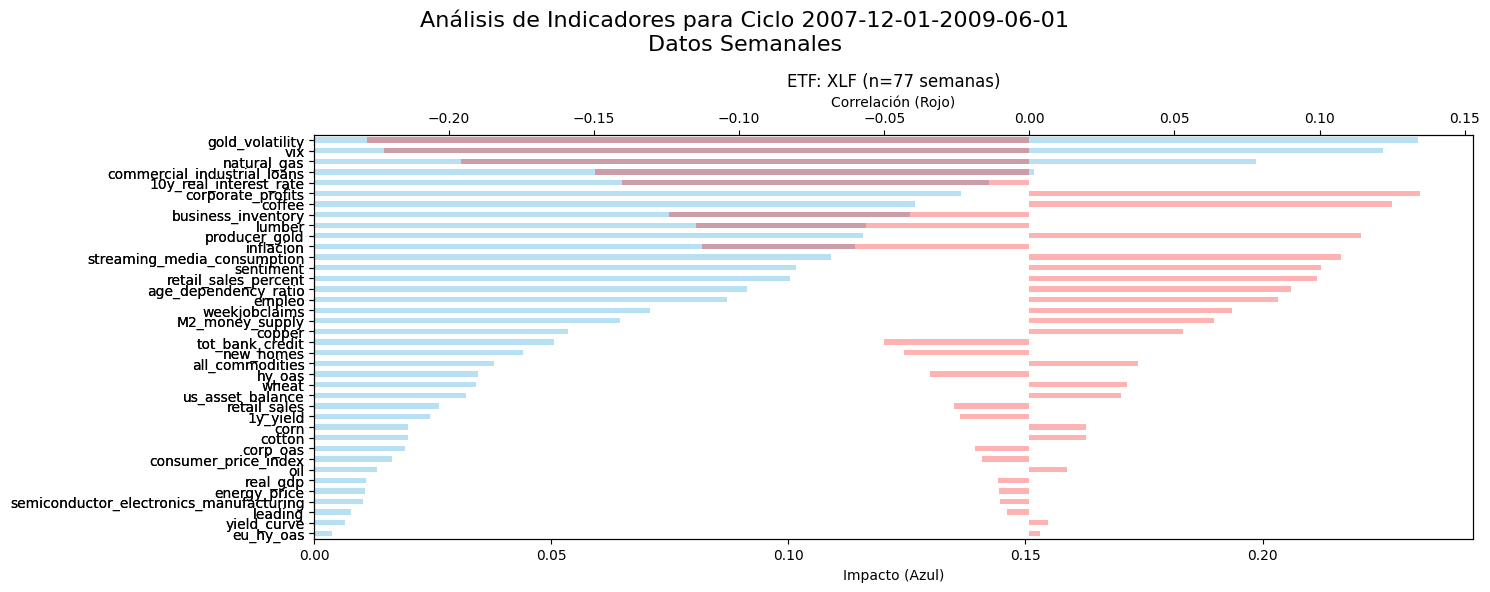

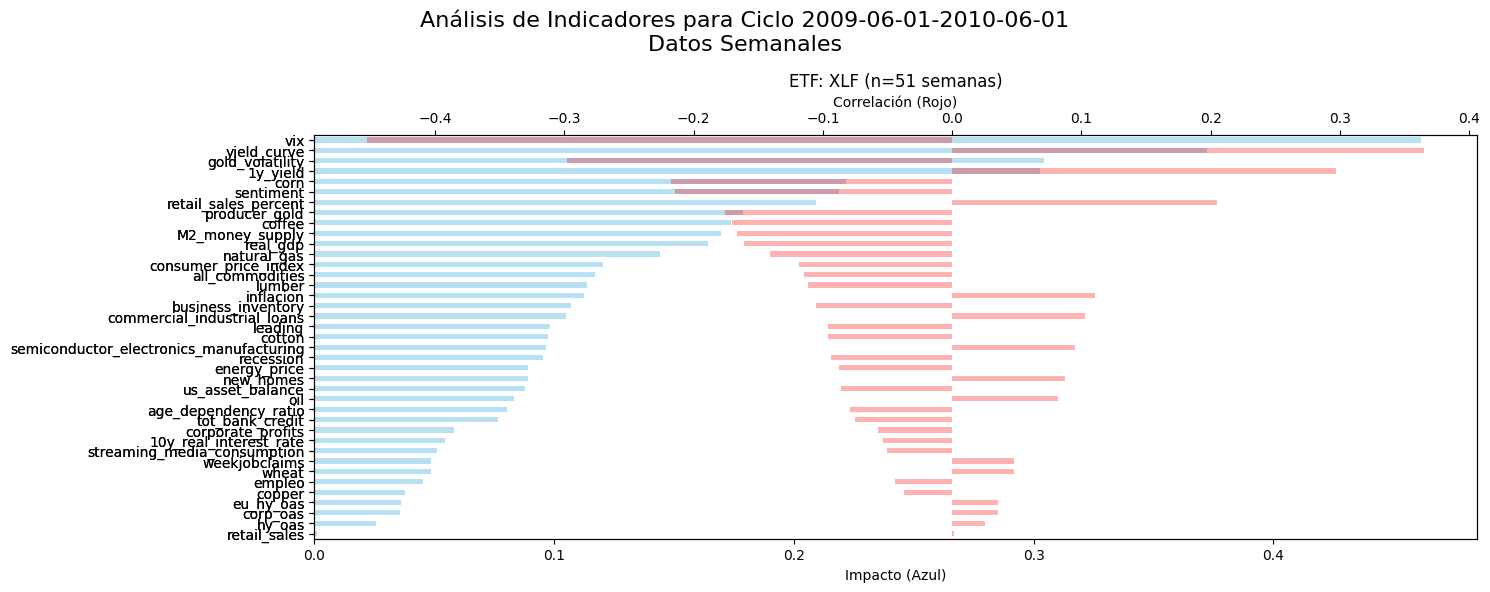

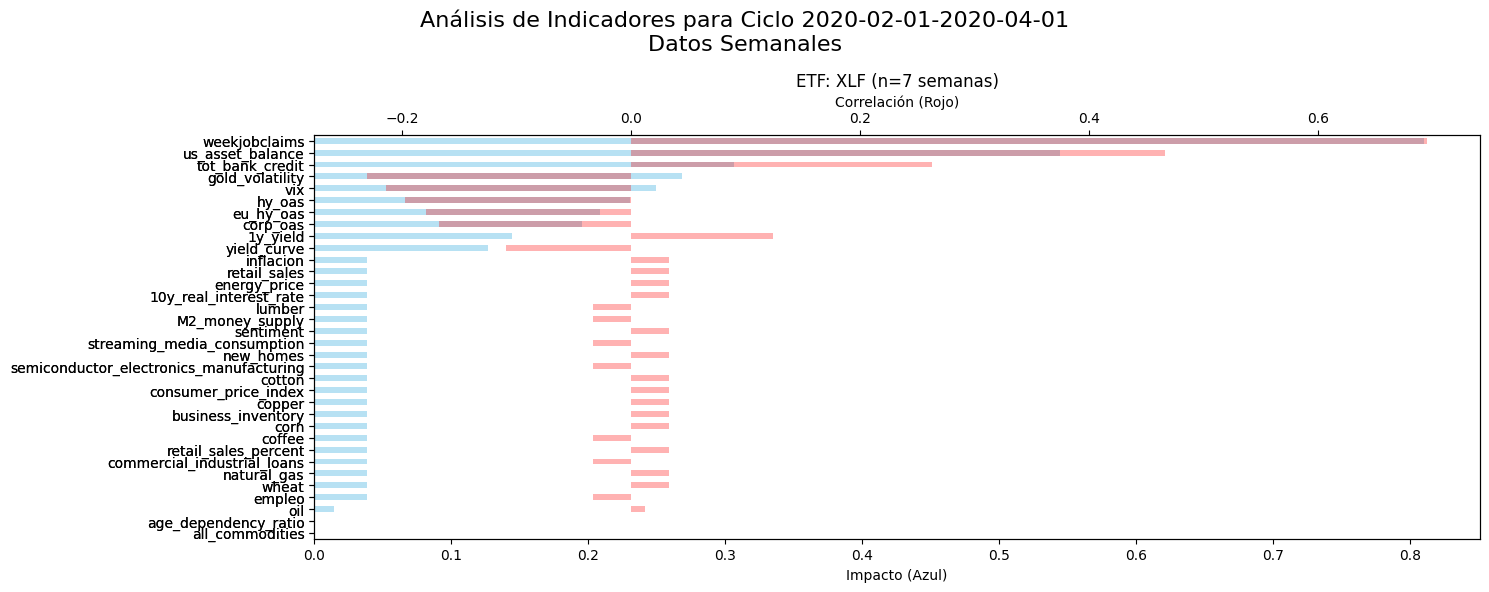

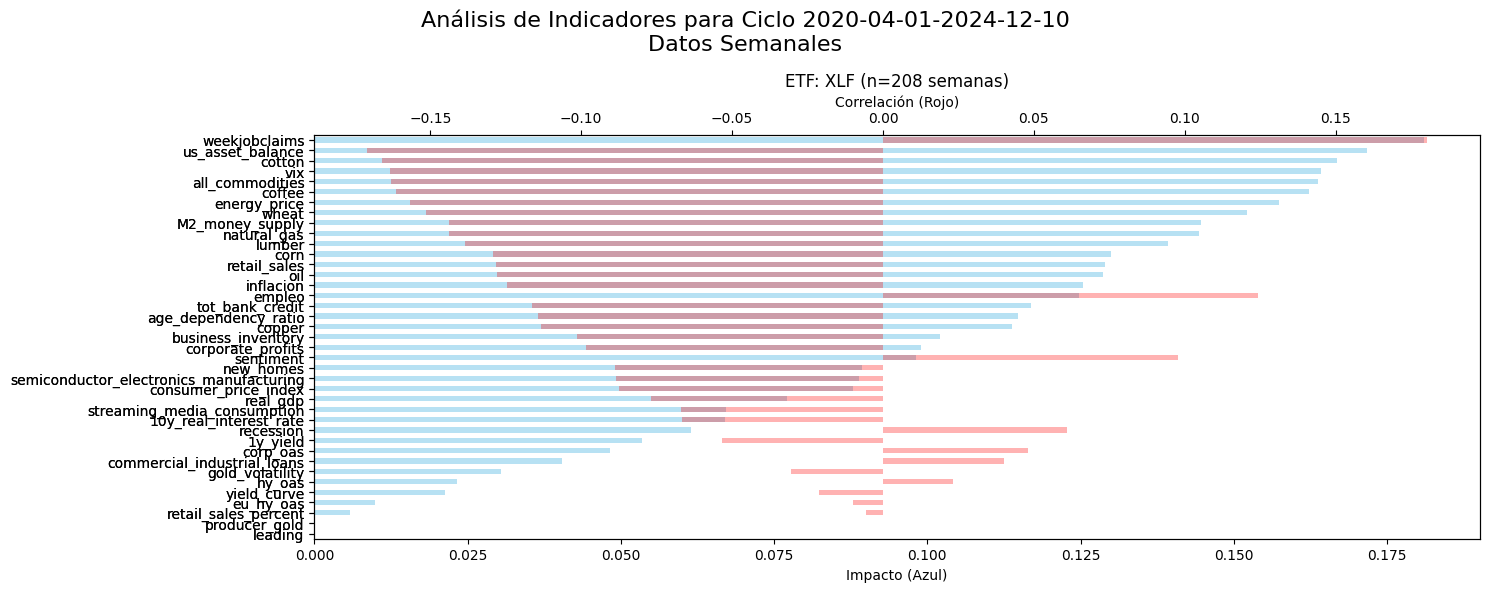

____________________________________________________________________________________________________


/tmp/ipykernel_170894/1113042025.py:76: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return data.fillna(method='ffill')
[*********************100%***********************]  1 of 1 completed
/home/muniia/Documents/TFM/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/muniia/Documents/TFM/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Resumen del análisis:
   ETF Top_Indicator_Impact  Impact_Score Top_Indicator_Corr  Correlation  \
0  XLP                  vix      0.158622                vix    -0.158121   
1  XLP      gold_volatility      0.335141    gold_volatility    -0.328696   
2  XLP                  vix      0.426848                vix    -0.418478   
3  XLP        weekjobclaims      0.593424      weekjobclaims     0.508649   
4  XLP                  vix      0.143814                vix    -0.143122   

   N_Weeks                  Cycle  
0      317  2001-11-01-2007-12-01  
1       77  2007-12-01-2009-06-01  
2       51  2009-06-01-2010-06-01  
3        7  2020-02-01-2020-04-01  
4      208  2020-04-01-2024-12-10  


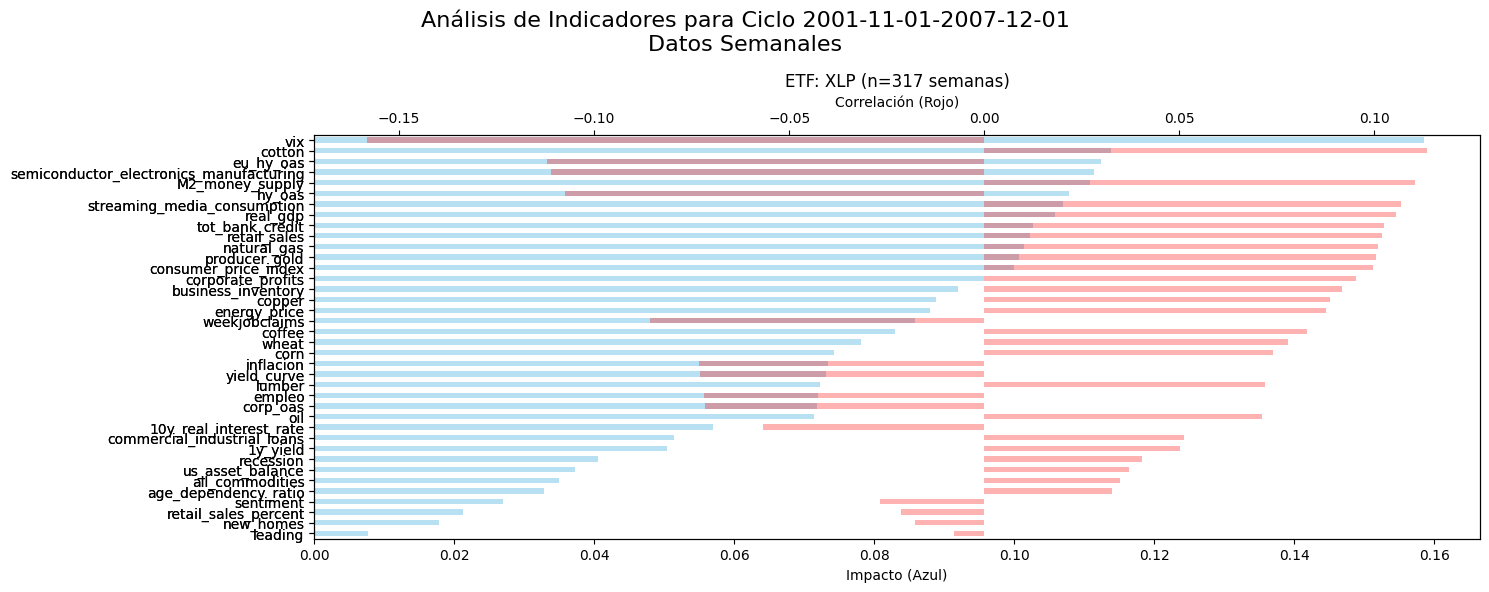

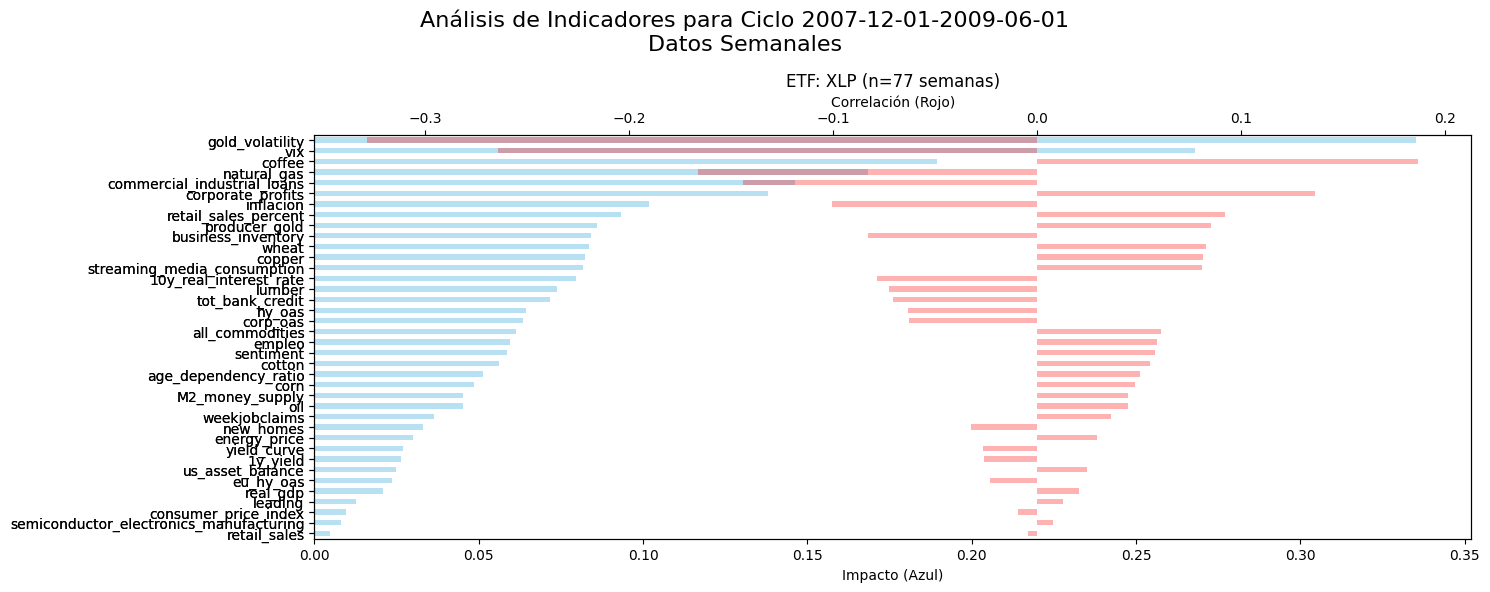

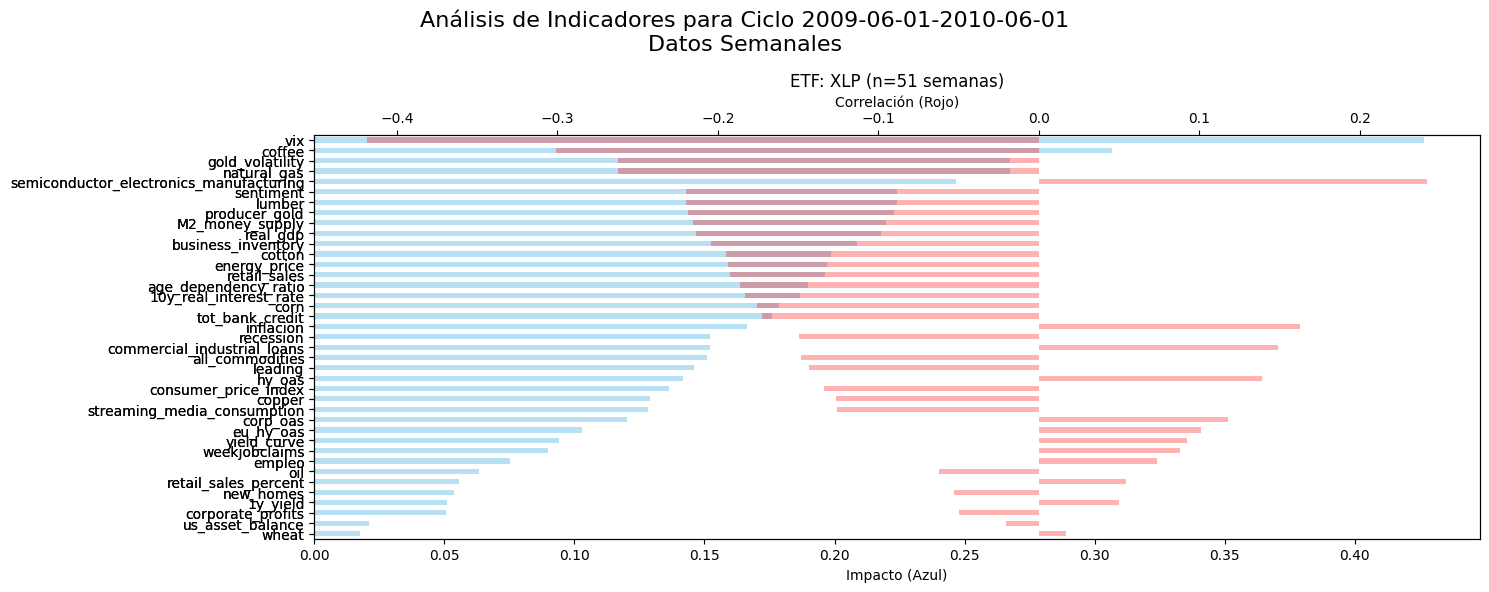

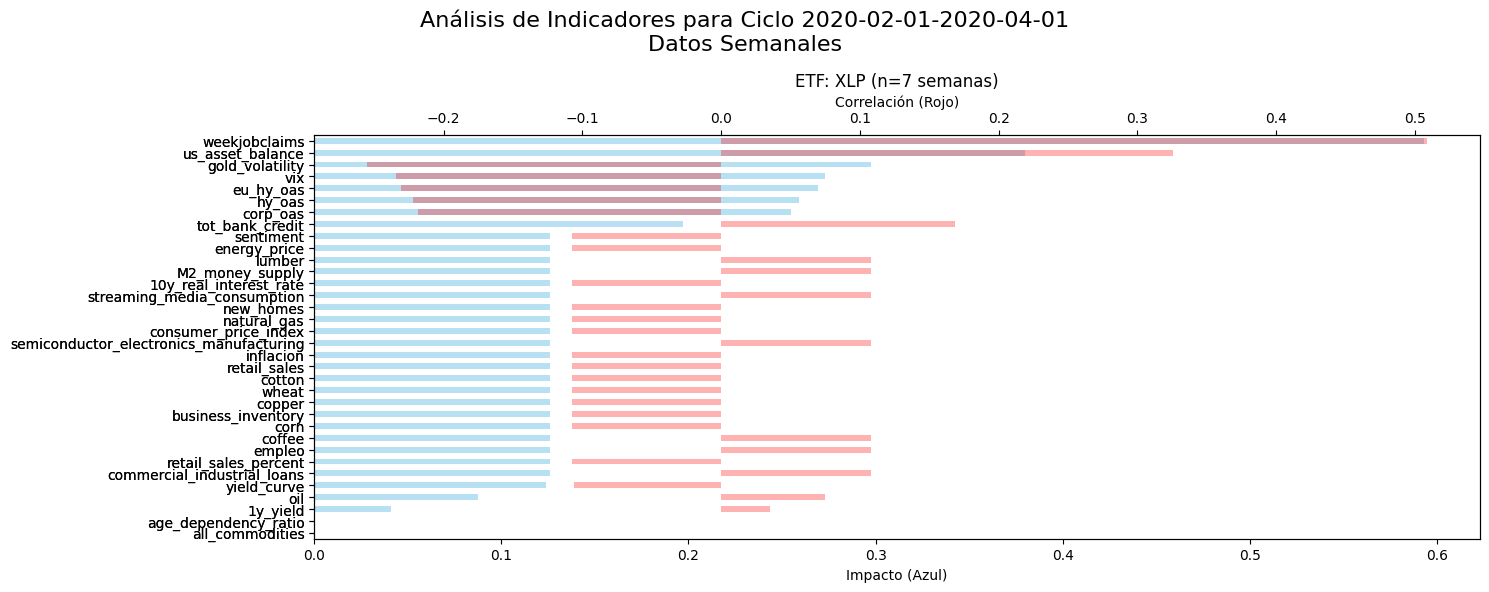

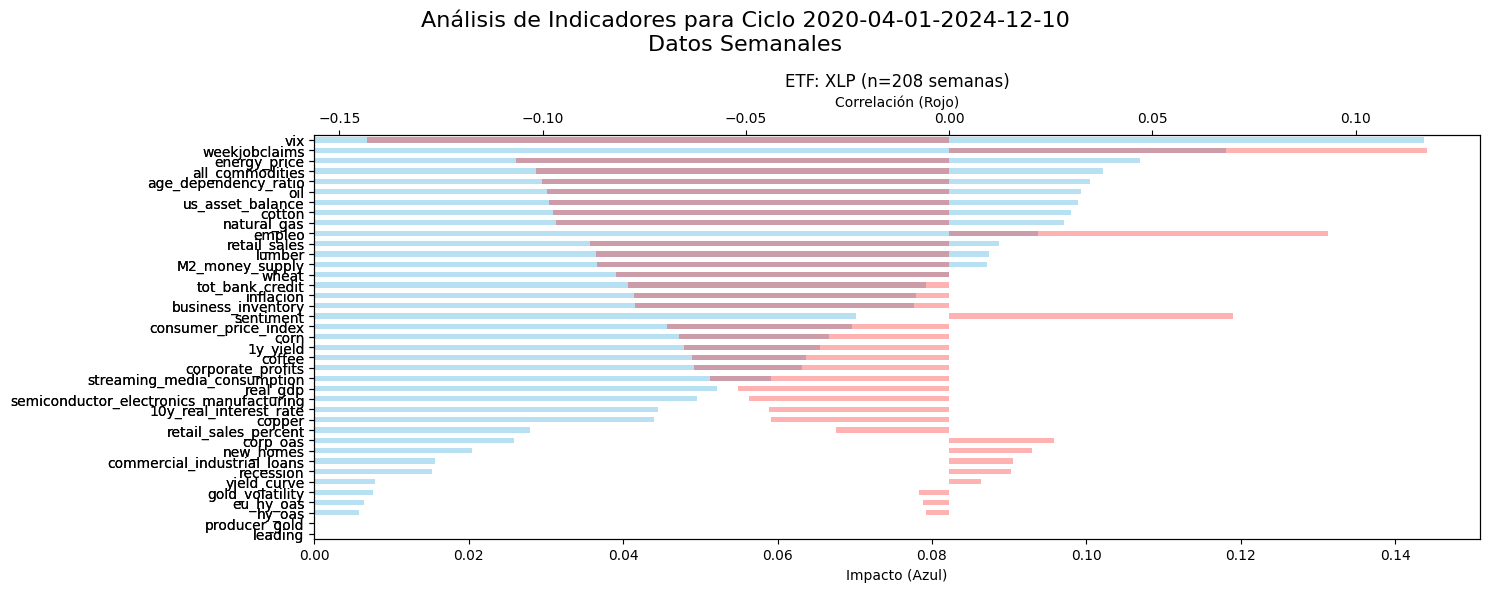

____________________________________________________________________________________________________


/tmp/ipykernel_170894/1113042025.py:76: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return data.fillna(method='ffill')
[*********************100%***********************]  1 of 1 completed
/home/muniia/Documents/TFM/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/muniia/Documents/TFM/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Resumen del análisis:
   ETF Top_Indicator_Impact  Impact_Score Top_Indicator_Corr  Correlation  \
0  XLY                  vix      0.184882                vix    -0.184298   
1  XLY      gold_volatility      0.231806    gold_volatility    -0.227348   
2  XLY                  vix      0.530291                vix    -0.519893   
3  XLY        weekjobclaims      0.813205      weekjobclaims     0.697033   
4  XLY        weekjobclaims      0.269281      weekjobclaims     0.267986   

   N_Weeks                  Cycle  
0      317  2001-11-01-2007-12-01  
1       77  2007-12-01-2009-06-01  
2       51  2009-06-01-2010-06-01  
3        7  2020-02-01-2020-04-01  
4      208  2020-04-01-2024-12-10  


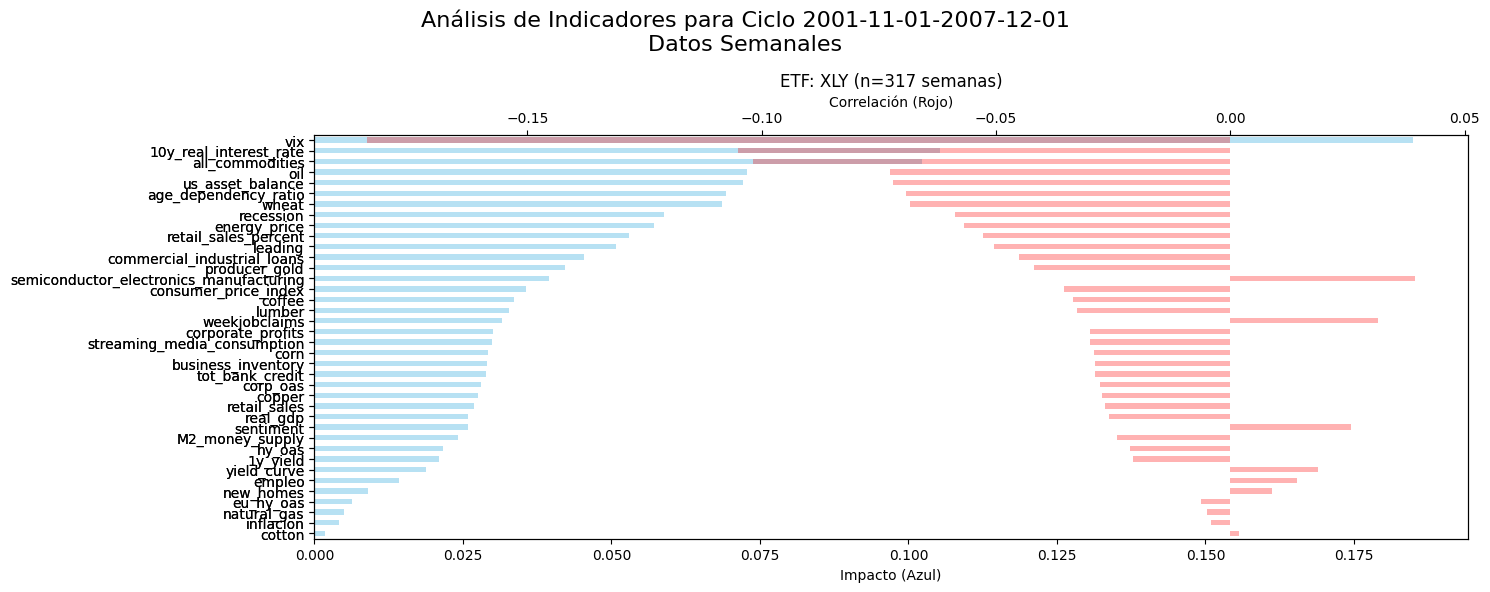

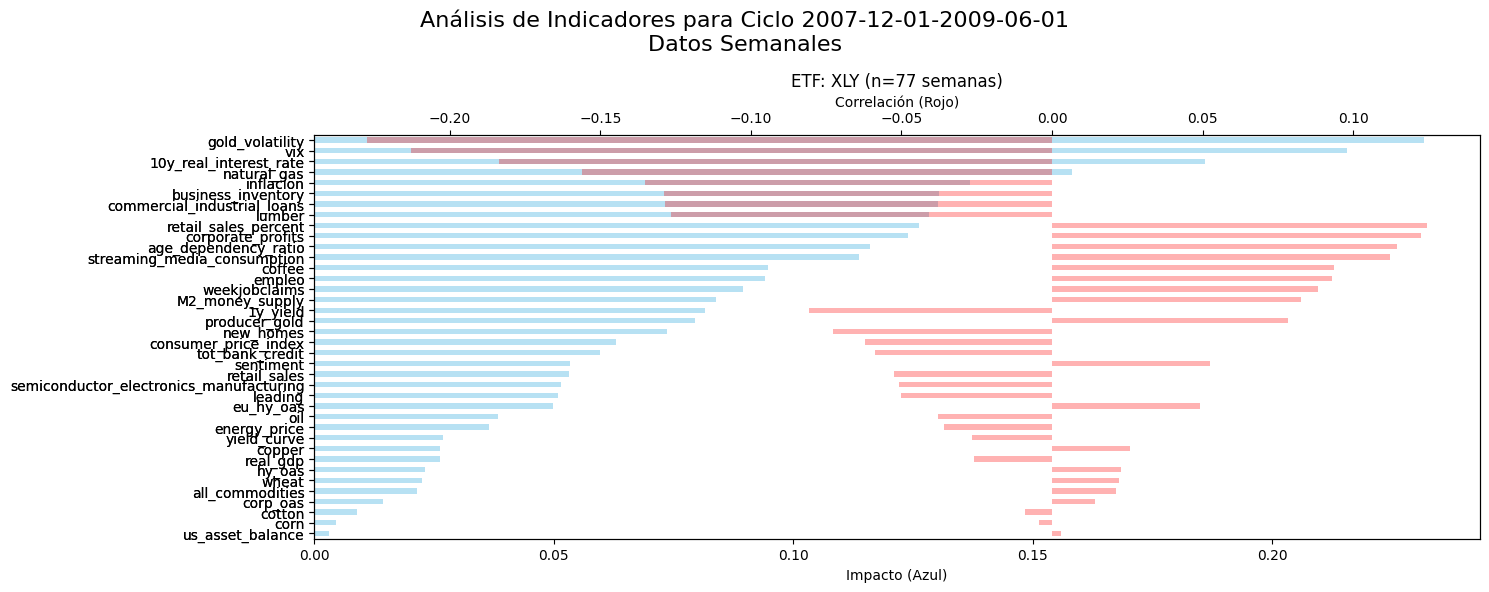

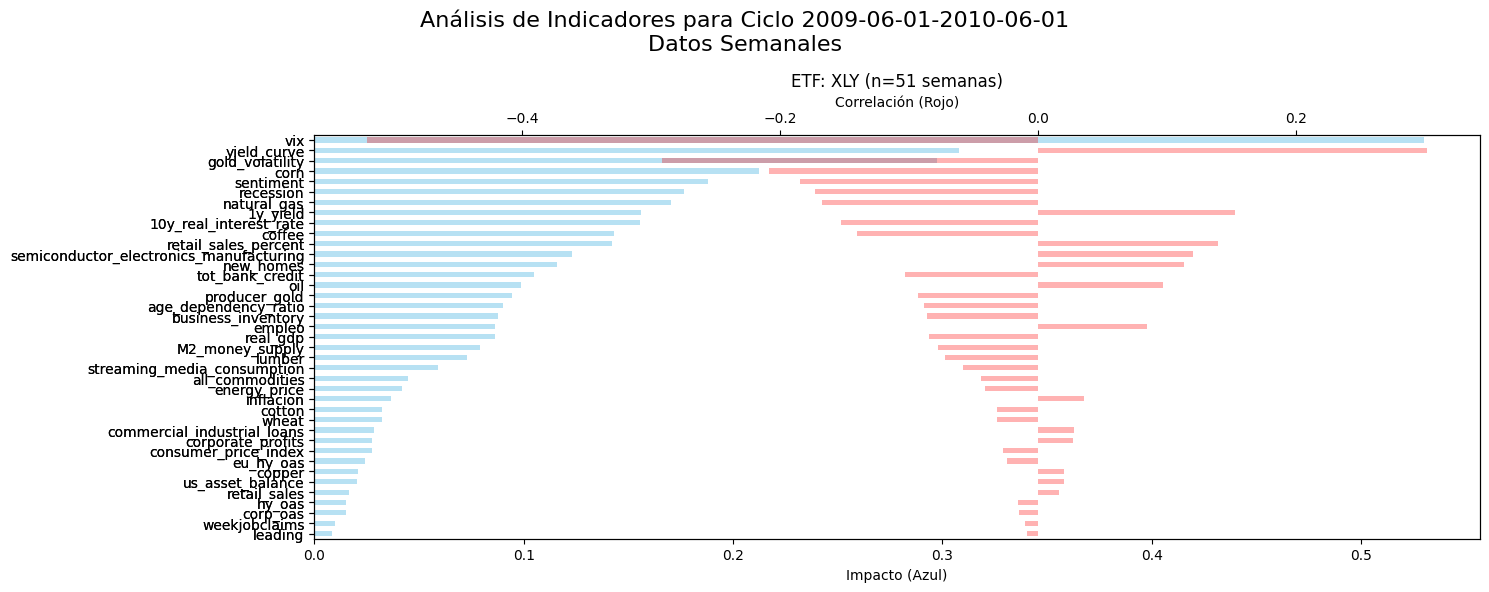

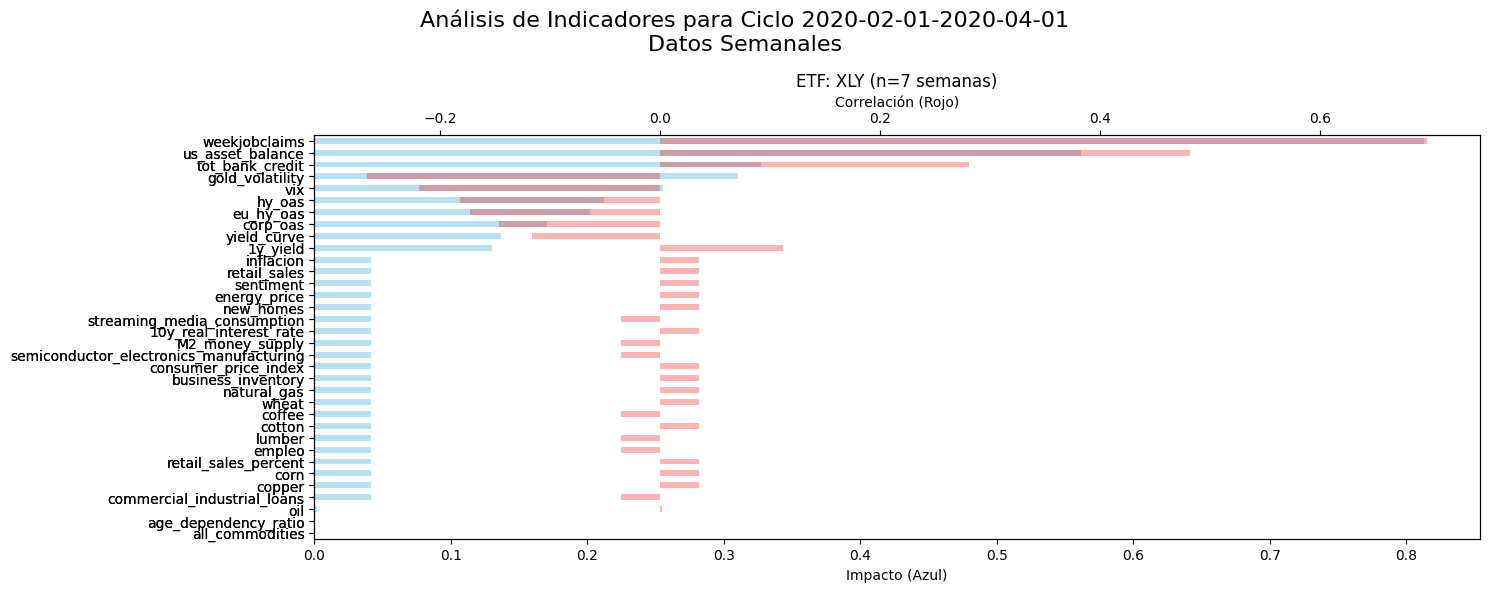

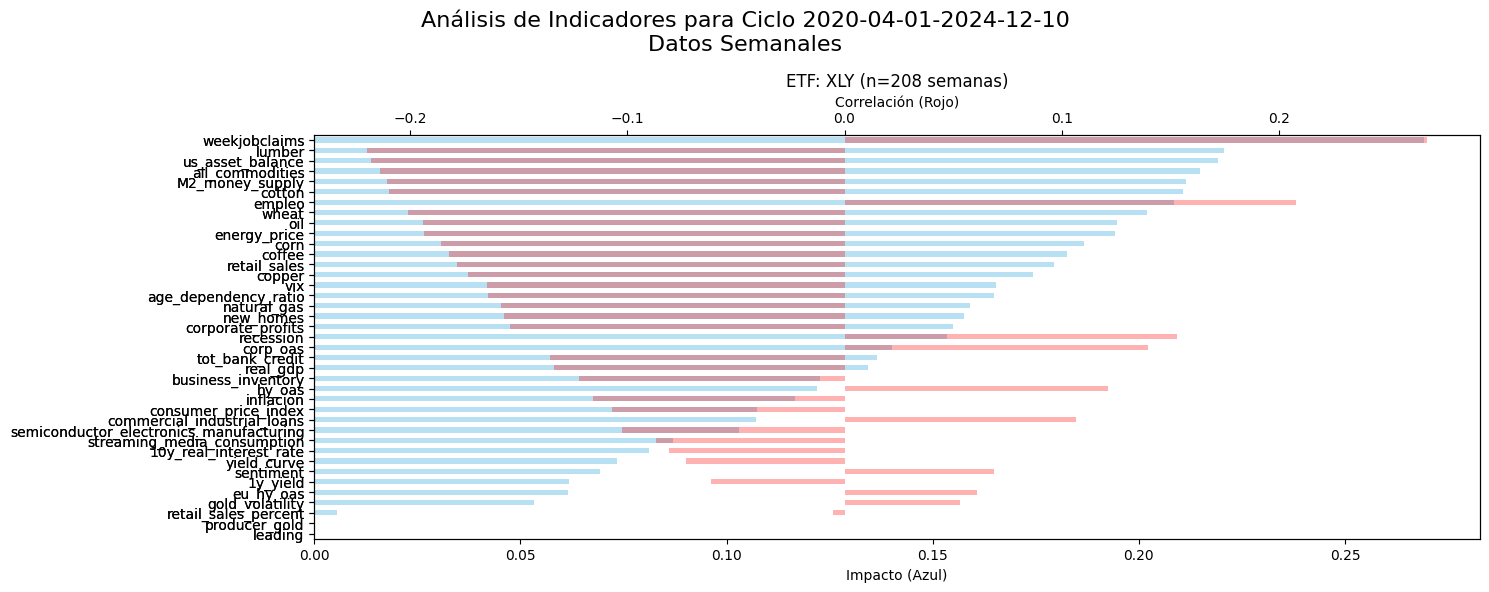

____________________________________________________________________________________________________


/tmp/ipykernel_170894/1113042025.py:76: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return data.fillna(method='ffill')
[*********************100%***********************]  1 of 1 completed
/home/muniia/Documents/TFM/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/muniia/Documents/TFM/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Resumen del análisis:
   ETF Top_Indicator_Impact  Impact_Score Top_Indicator_Corr  Correlation  \
0  XLV              leading      0.083600            leading    -0.083337   
1  XLV      gold_volatility      0.297926    gold_volatility    -0.292197   
2  XLV                  vix      0.401868                vix    -0.393989   
3  XLV        weekjobclaims      0.647056      weekjobclaims     0.554619   
4  XLV        weekjobclaims      0.223050      weekjobclaims     0.221978   

   N_Weeks                  Cycle  
0      317  2001-11-01-2007-12-01  
1       77  2007-12-01-2009-06-01  
2       51  2009-06-01-2010-06-01  
3        7  2020-02-01-2020-04-01  
4      208  2020-04-01-2024-12-10  


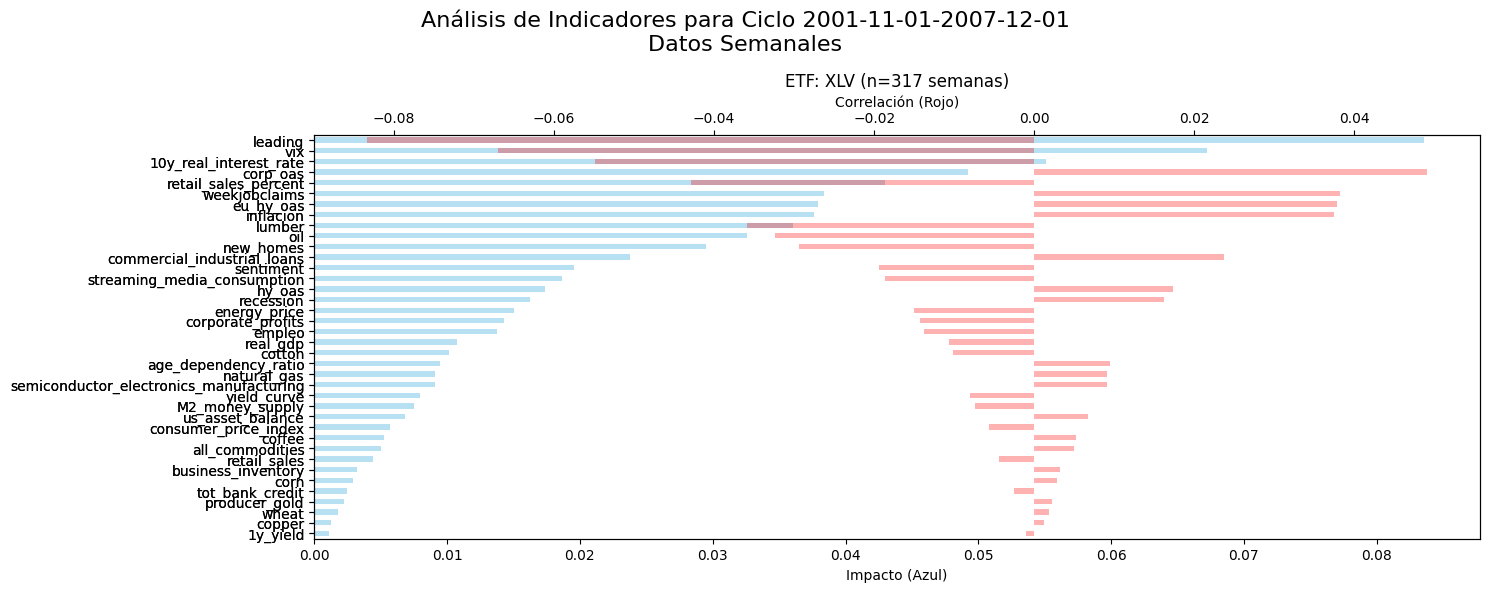

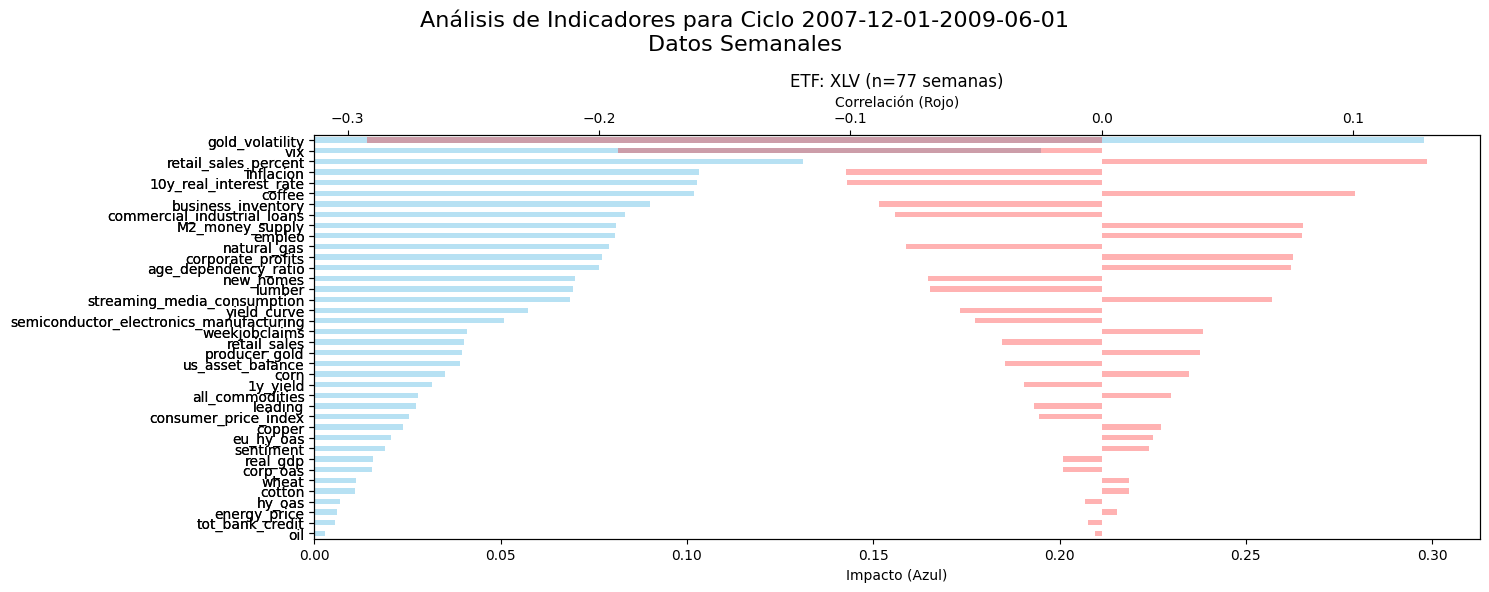

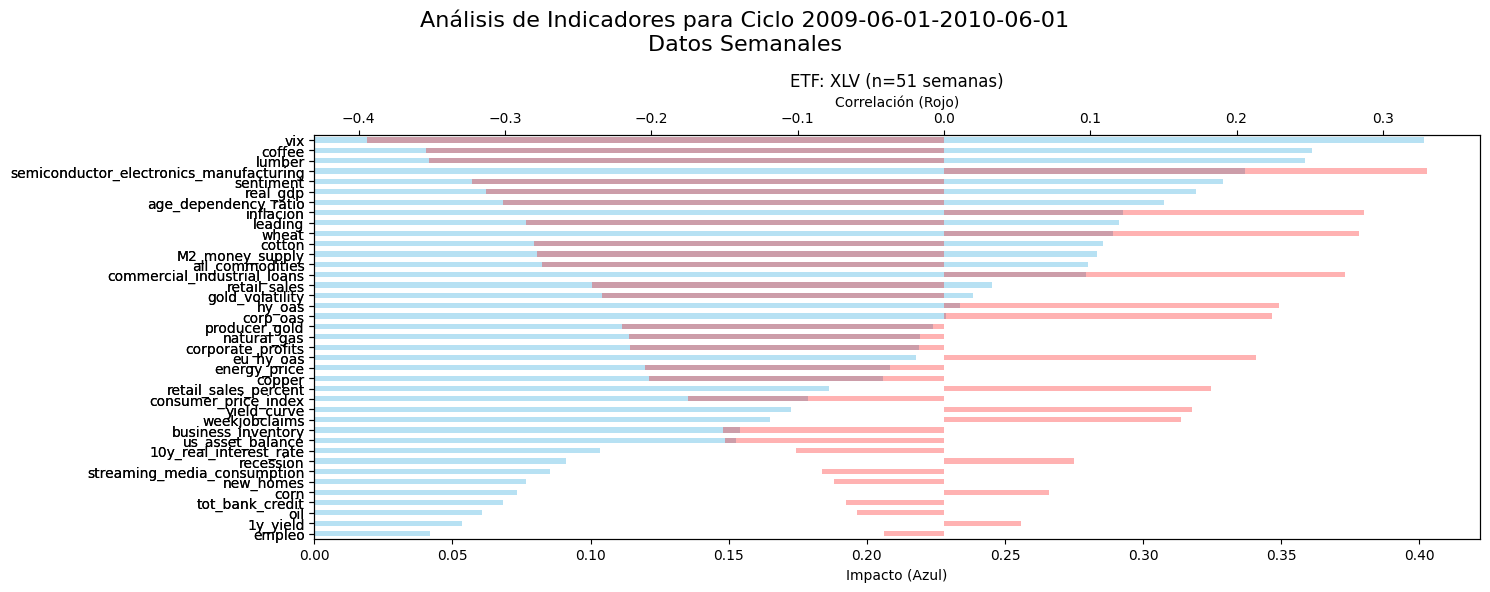

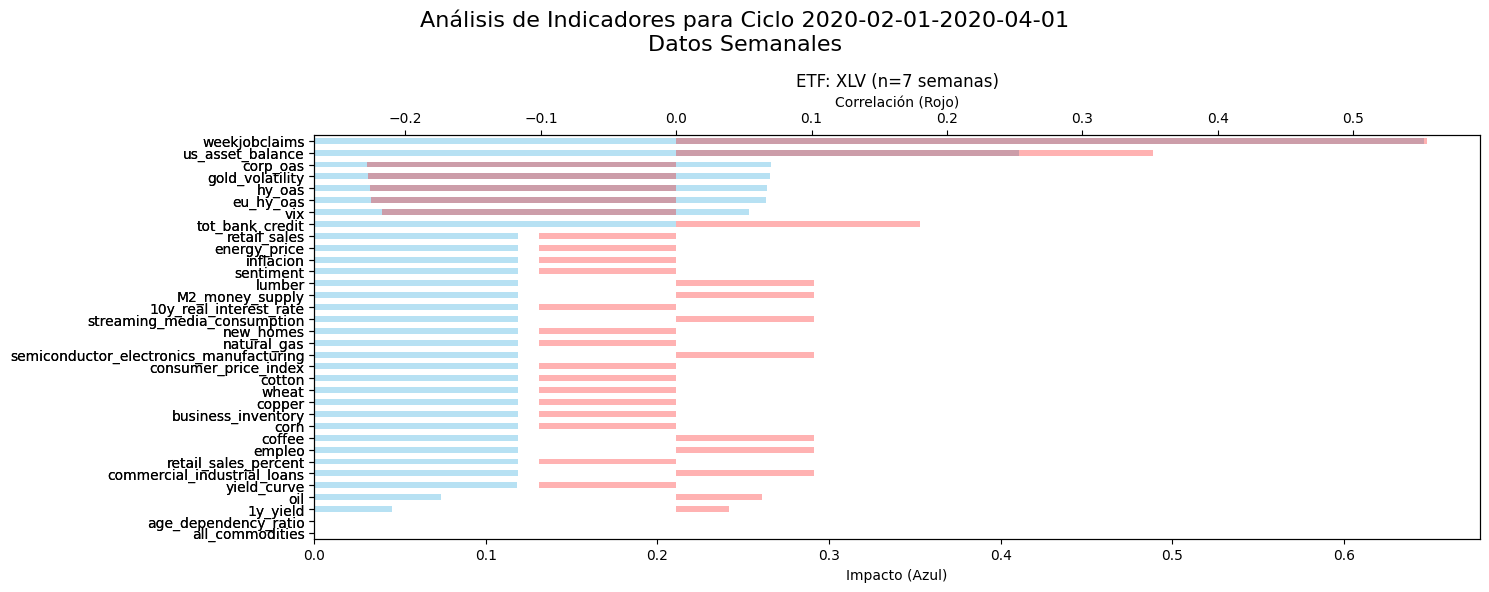

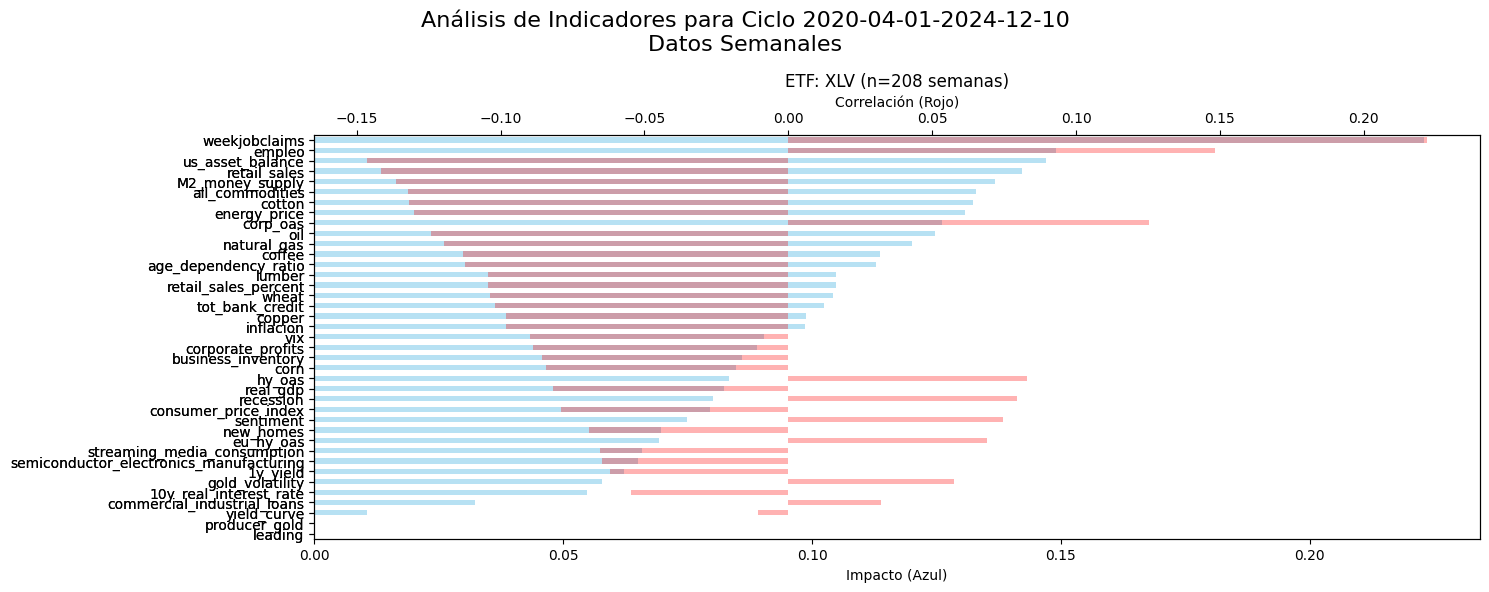

____________________________________________________________________________________________________


/tmp/ipykernel_170894/1113042025.py:76: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return data.fillna(method='ffill')
[*********************100%***********************]  1 of 1 completed
/home/muniia/Documents/TFM/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/muniia/Documents/TFM/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Resumen del análisis:
   ETF Top_Indicator_Impact  Impact_Score Top_Indicator_Corr  Correlation  \
0  XLU                  vix      0.225215                vix    -0.224504   
1  XLU      gold_volatility      0.182630    gold_volatility    -0.179118   
2  XLU                  vix      0.421647                vix    -0.413380   
3  XLU        weekjobclaims      0.745142      weekjobclaims     0.638693   
4  XLU        weekjobclaims      0.176333      weekjobclaims     0.175485   

   N_Weeks                  Cycle  
0      317  2001-11-01-2007-12-01  
1       77  2007-12-01-2009-06-01  
2       51  2009-06-01-2010-06-01  
3        7  2020-02-01-2020-04-01  
4      208  2020-04-01-2024-12-10  


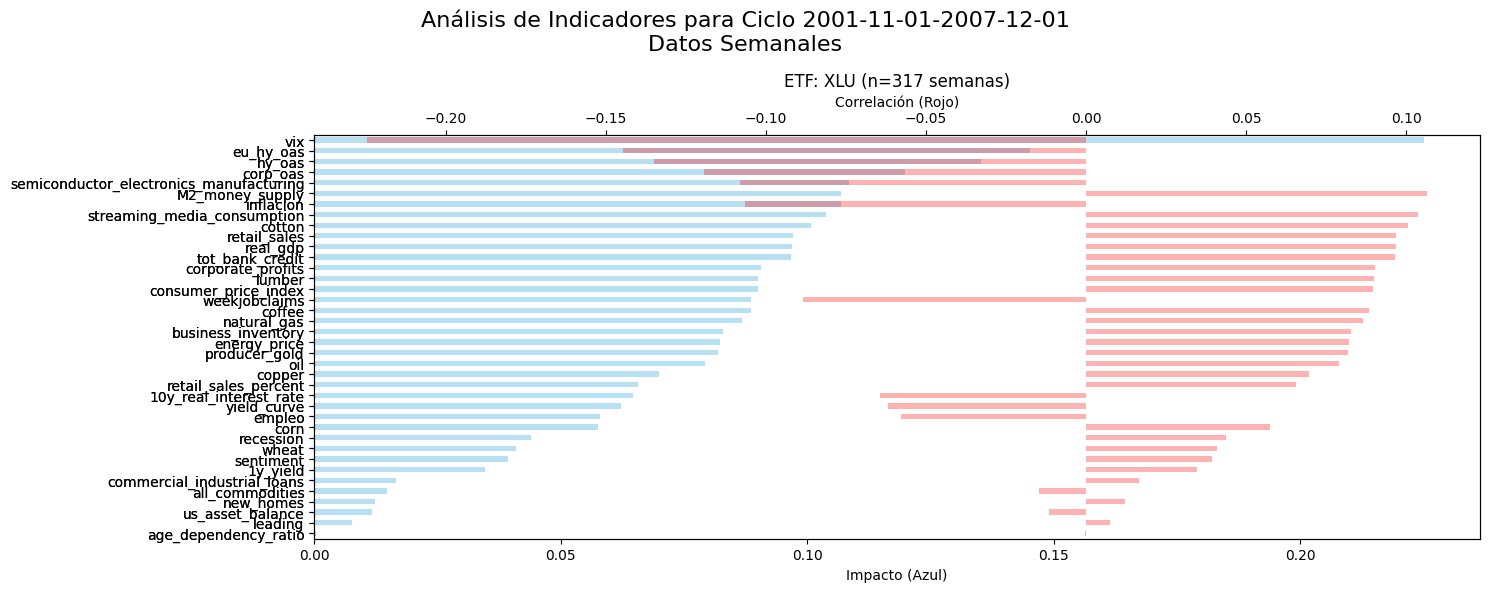

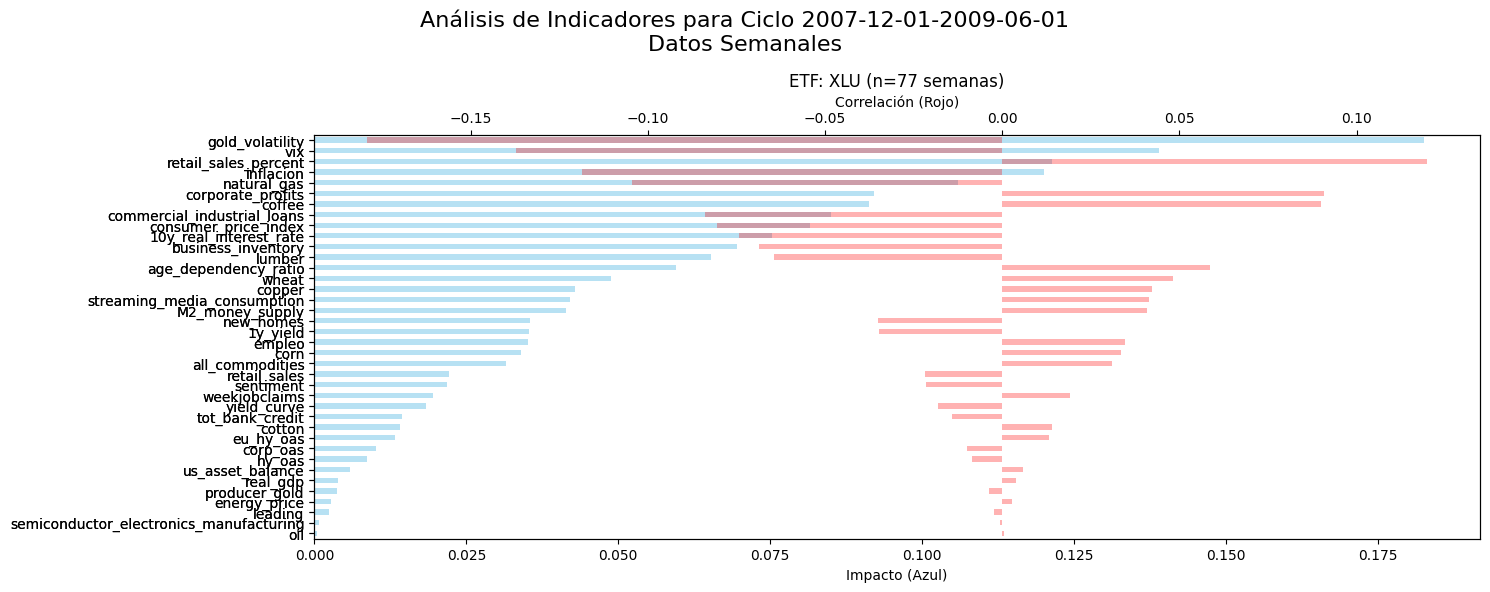

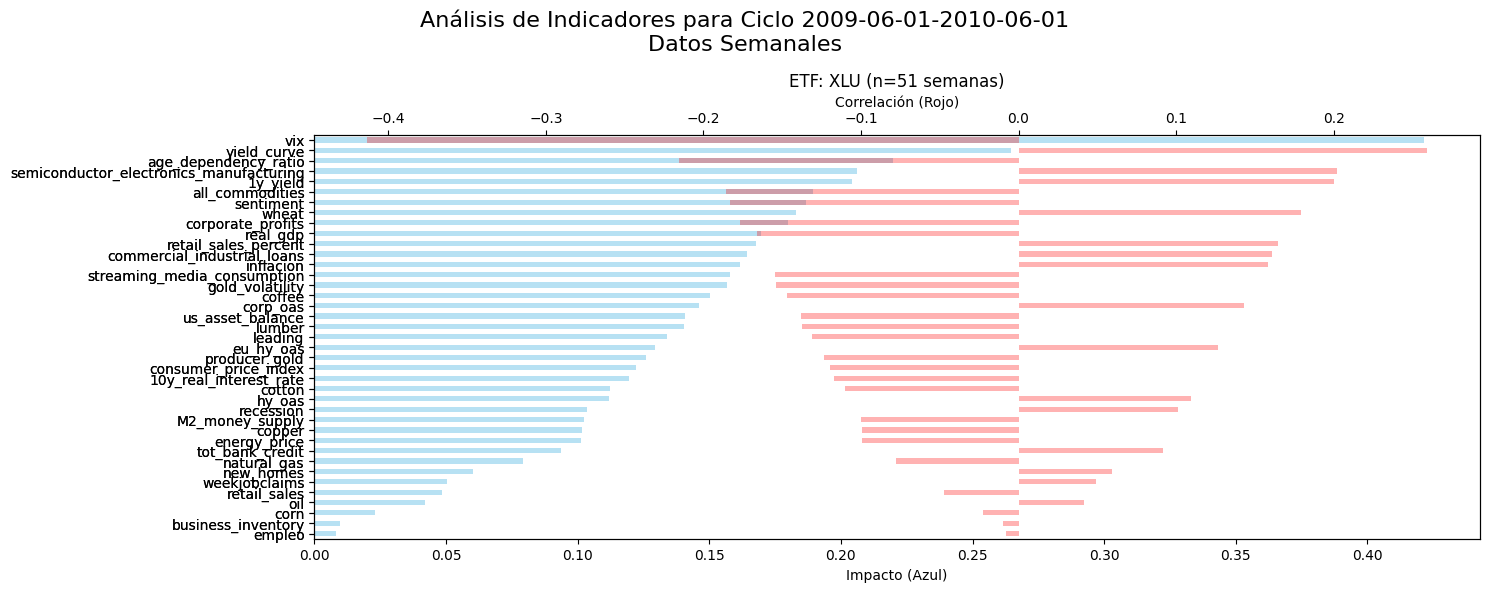

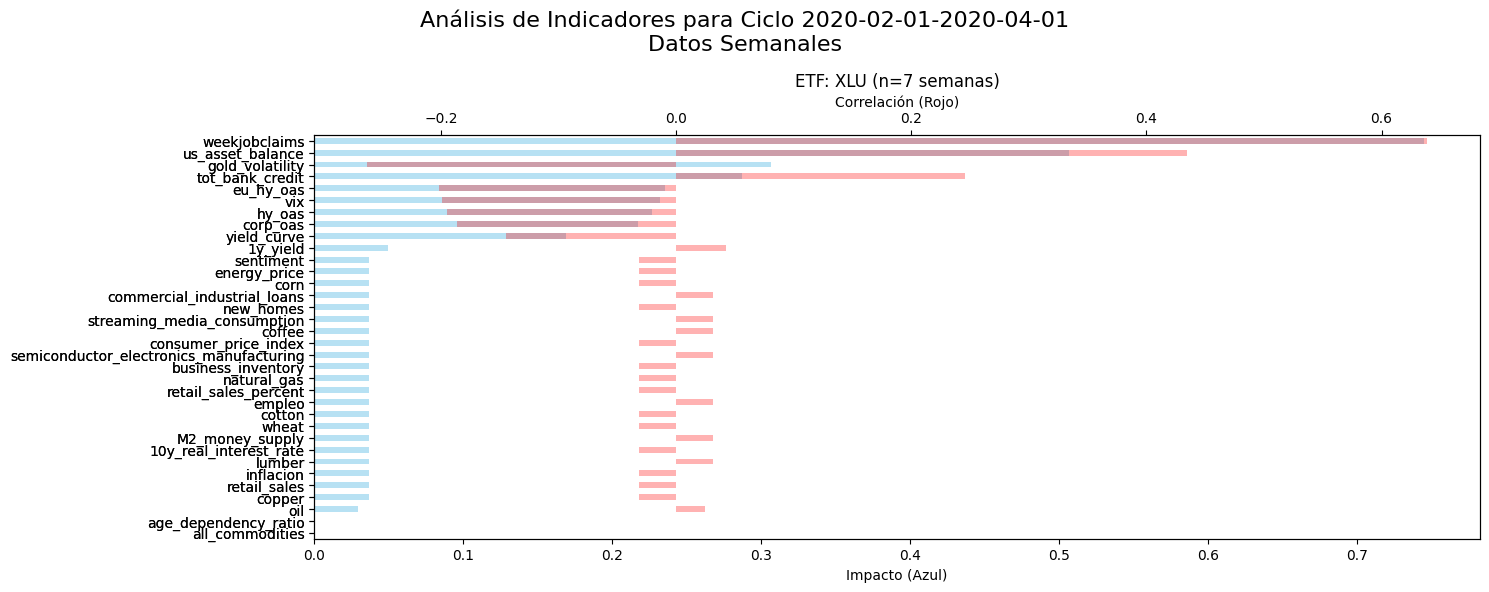

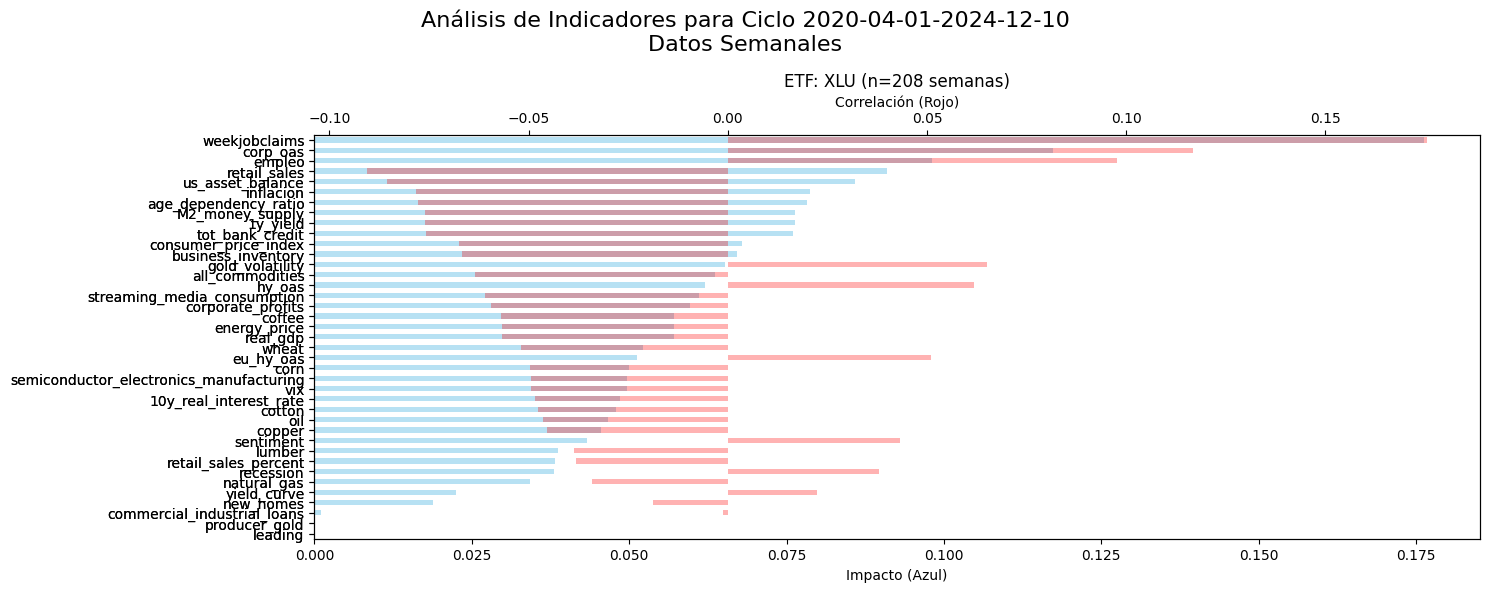

____________________________________________________________________________________________________


/tmp/ipykernel_170894/1113042025.py:76: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return data.fillna(method='ffill')
[*********************100%***********************]  1 of 1 completed
/home/muniia/Documents/TFM/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/muniia/Documents/TFM/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Resumen del análisis:
   ETF Top_Indicator_Impact  Impact_Score Top_Indicator_Corr  Correlation  \
0  IYR                  vix      0.133495                vix    -0.133074   
1  IYR                  vix      0.301693                vix    -0.297775   
2  IYR                  vix      0.387607                vix    -0.380007   
3  IYR        weekjobclaims      0.666560      weekjobclaims     0.571337   
4  IYR        weekjobclaims      0.215403      weekjobclaims     0.214368   

   N_Weeks                  Cycle  
0      317  2001-11-01-2007-12-01  
1       77  2007-12-01-2009-06-01  
2       51  2009-06-01-2010-06-01  
3        7  2020-02-01-2020-04-01  
4      208  2020-04-01-2024-12-10  


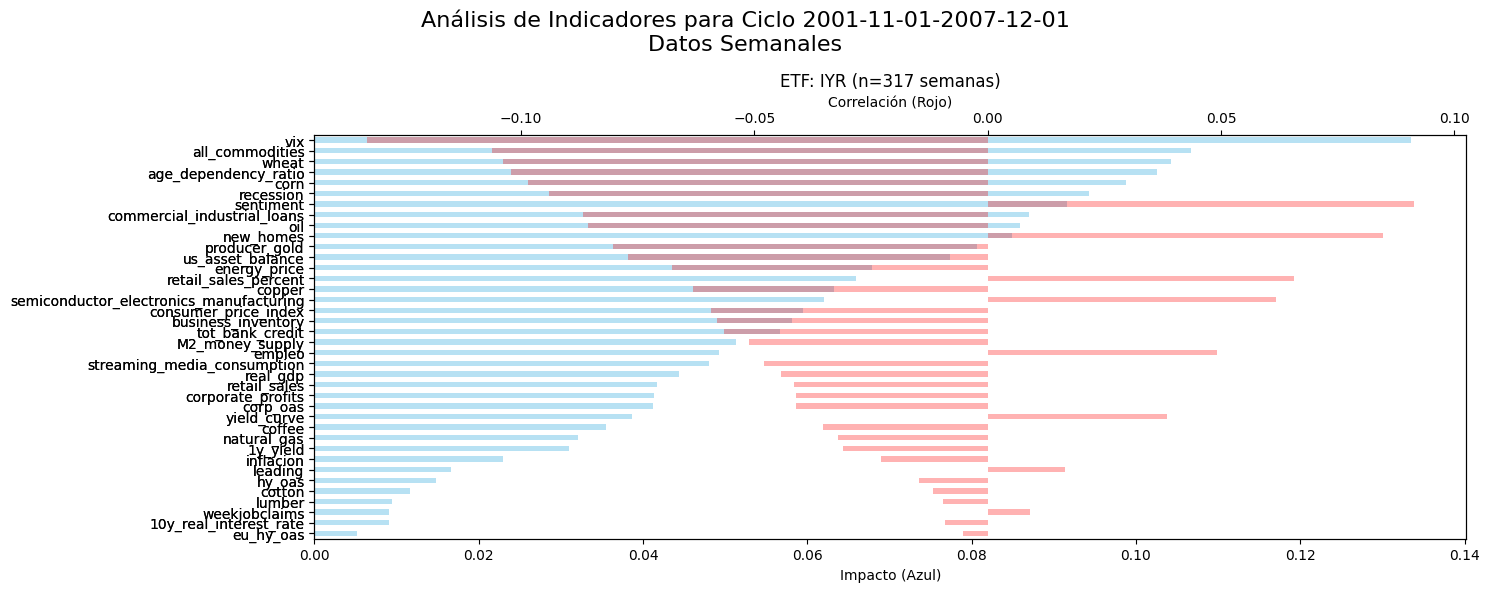

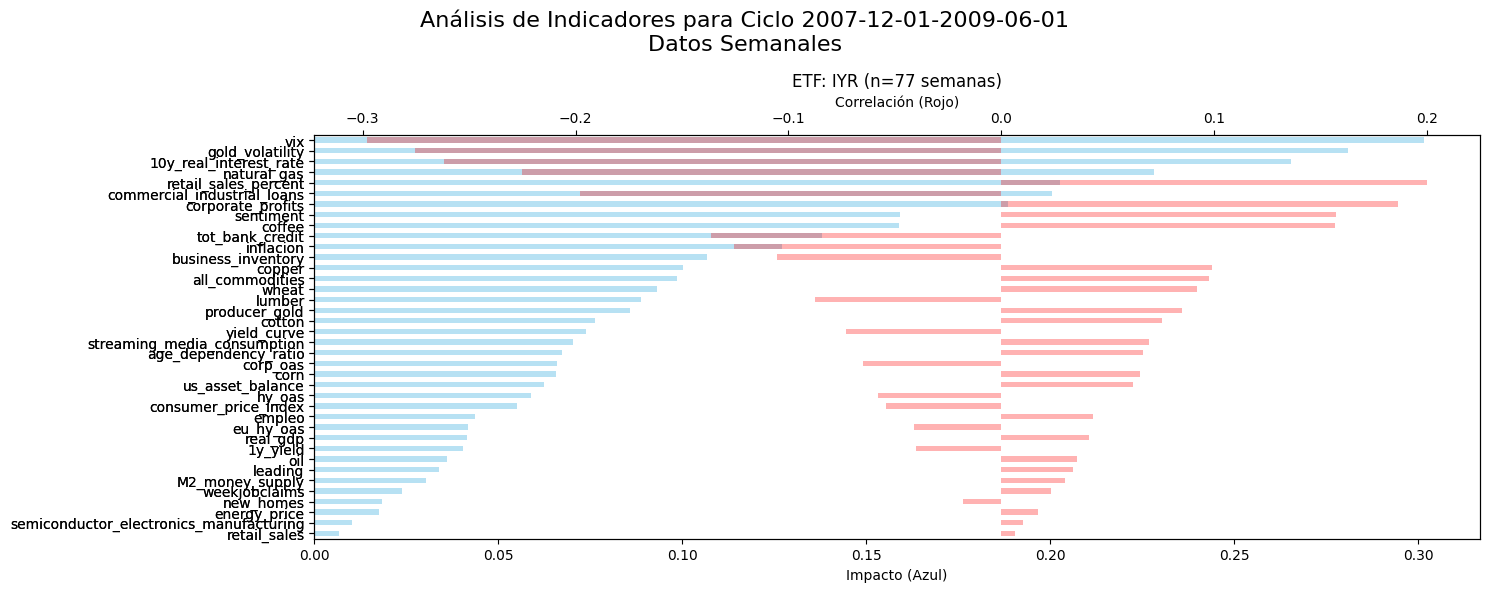

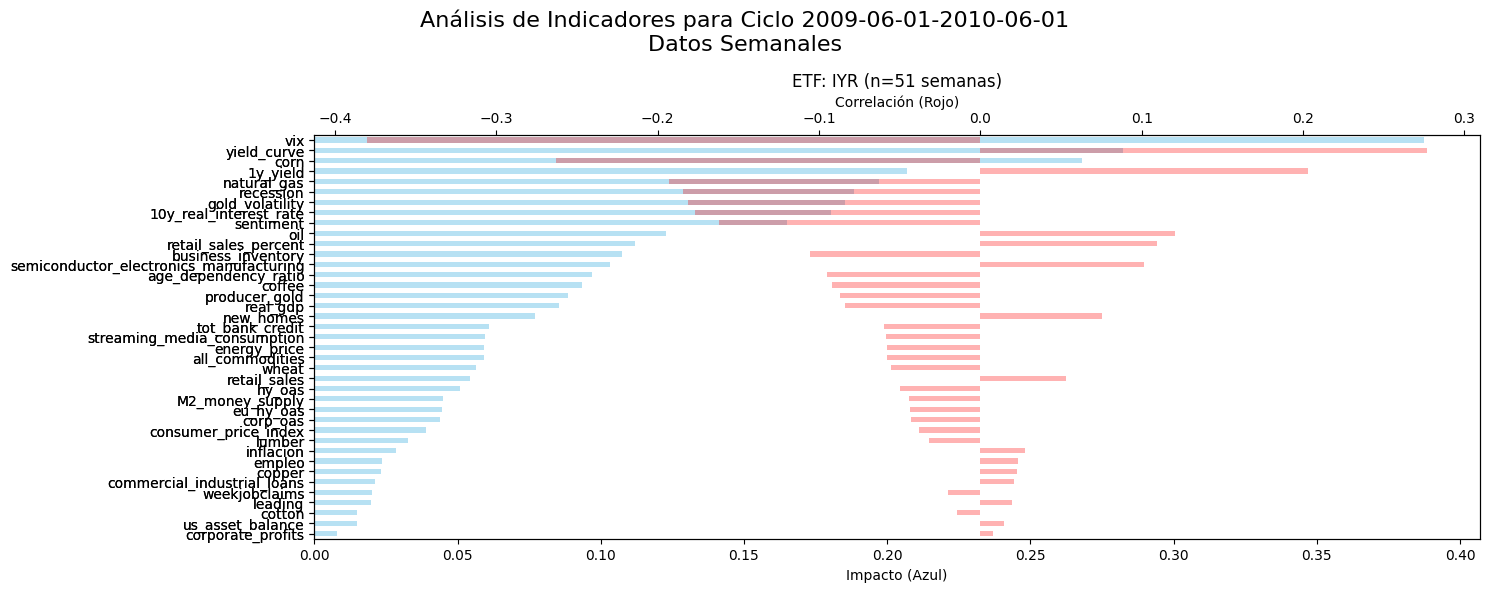

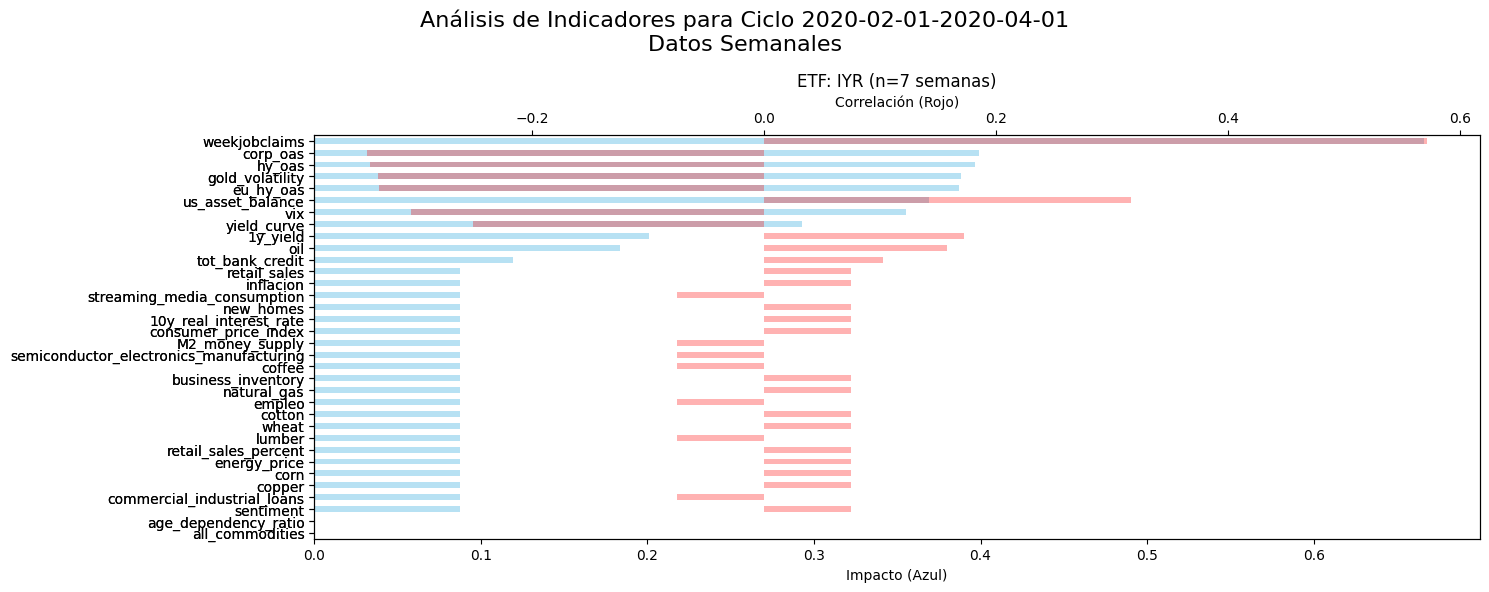

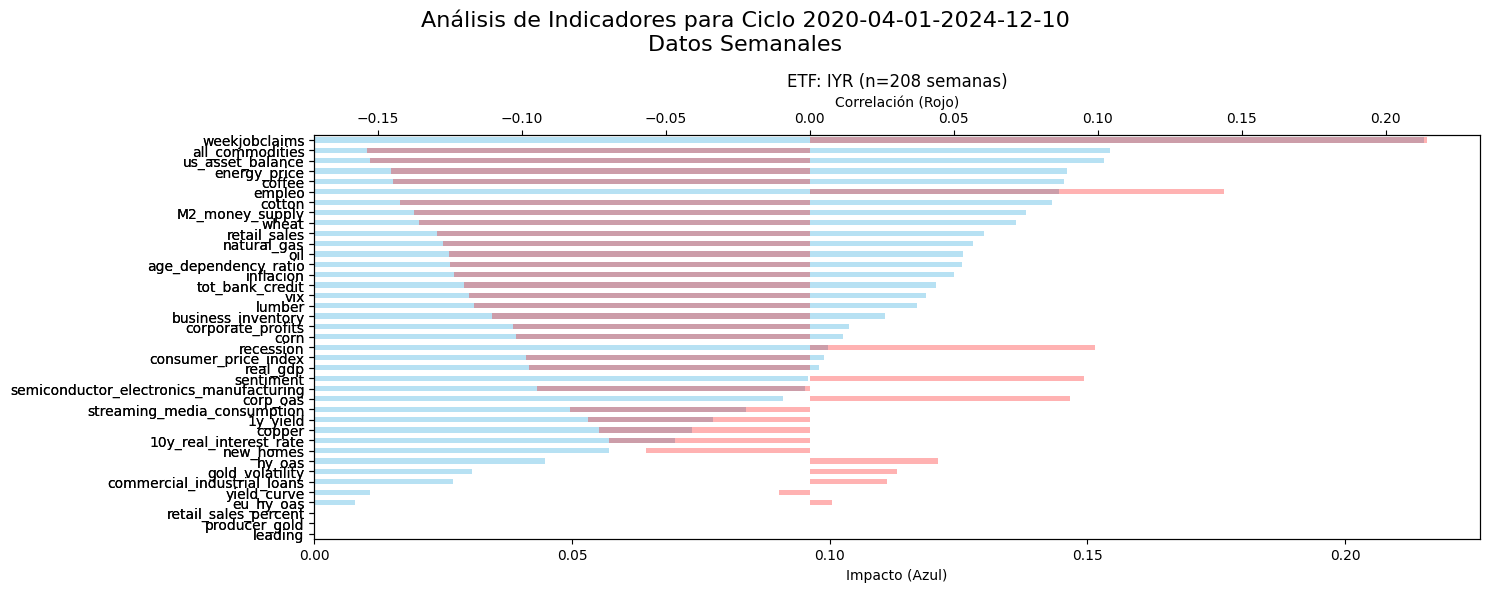

____________________________________________________________________________________________________


/tmp/ipykernel_170894/1113042025.py:76: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return data.fillna(method='ffill')
[*********************100%***********************]  1 of 1 completed
/home/muniia/Documents/TFM/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/muniia/Documents/TFM/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Resumen del análisis:
   ETF Top_Indicator_Impact  Impact_Score Top_Indicator_Corr  Correlation  \
0  VOX                  vix      0.328284                vix    -0.326295   
1  VOX      gold_volatility      0.182505    gold_volatility    -0.178996   
2  VOX                  vix      0.440715                vix    -0.432074   
3  VOX        weekjobclaims      0.741225      weekjobclaims     0.635335   
4  VOX               cotton      0.279542             cotton    -0.278198   

   N_Weeks                  Cycle  
0      165  2001-11-01-2007-12-01  
1       77  2007-12-01-2009-06-01  
2       51  2009-06-01-2010-06-01  
3        7  2020-02-01-2020-04-01  
4      208  2020-04-01-2024-12-10  


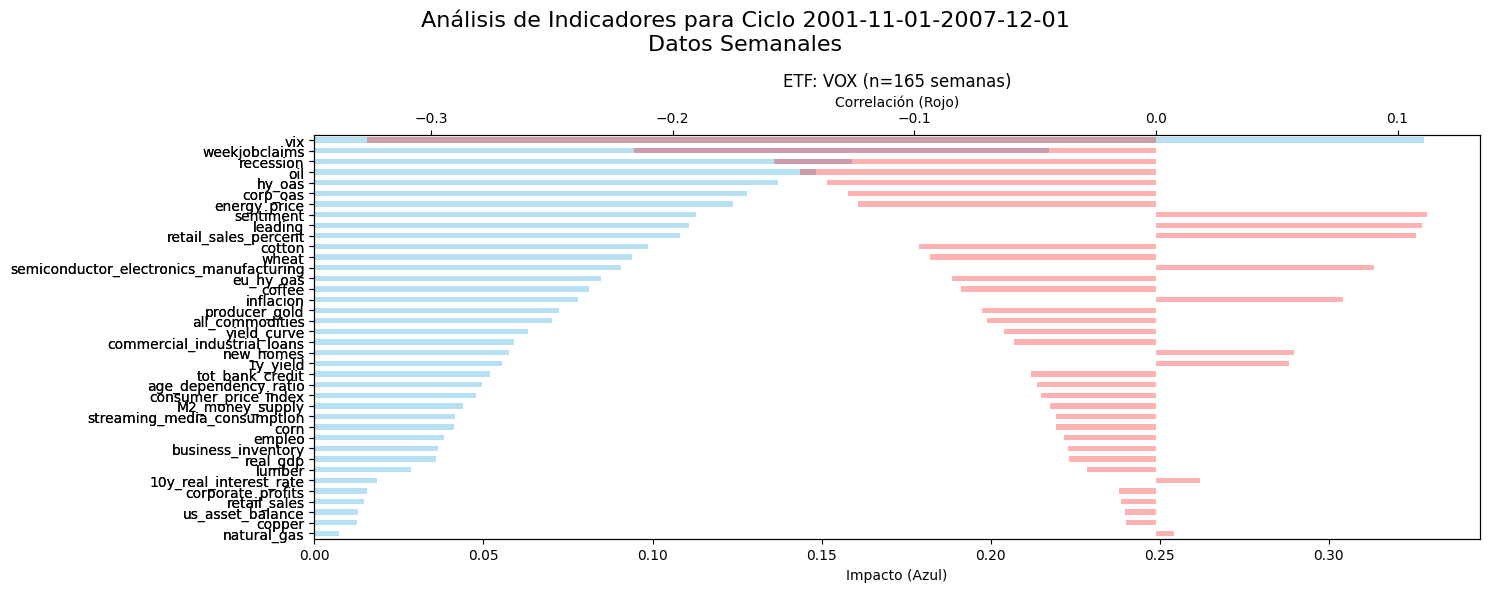

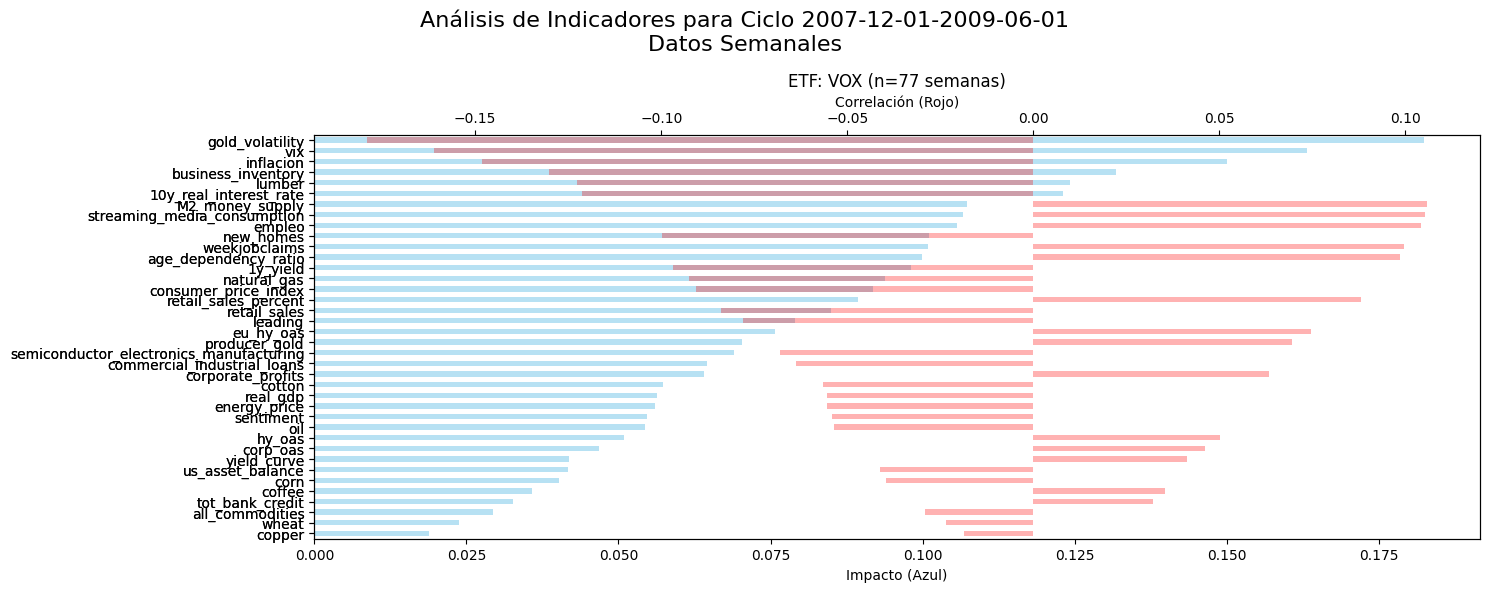

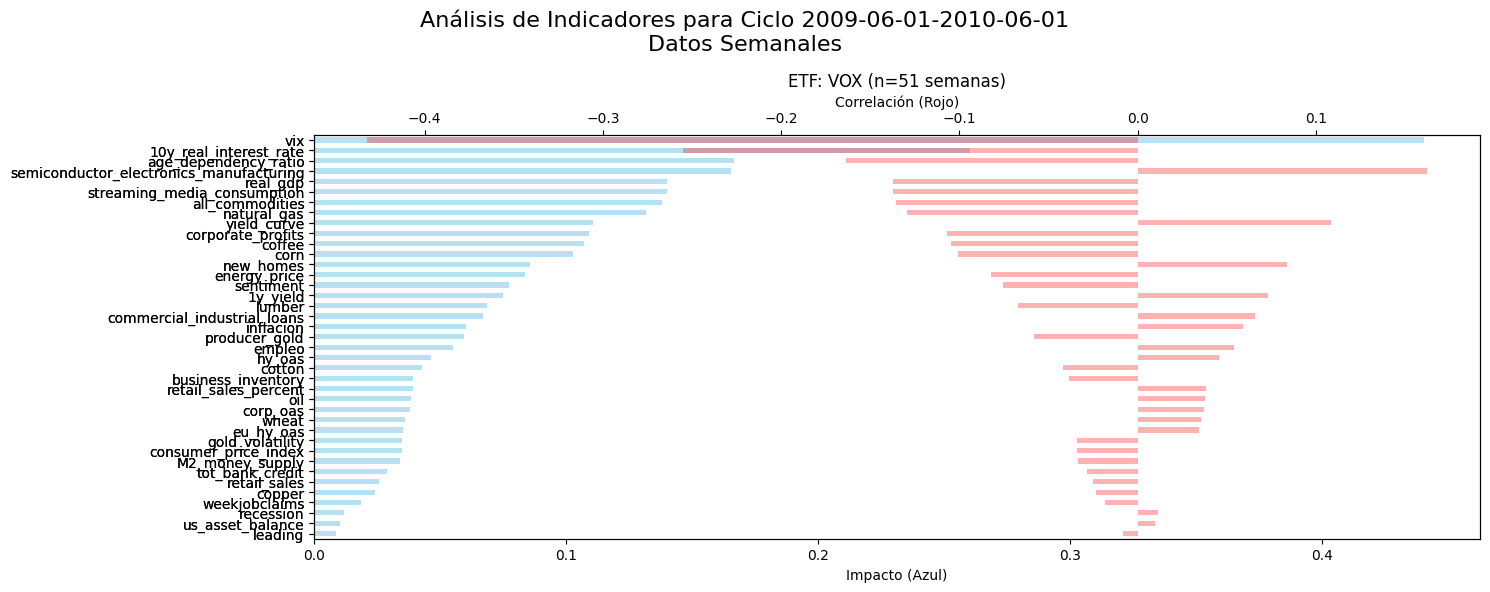

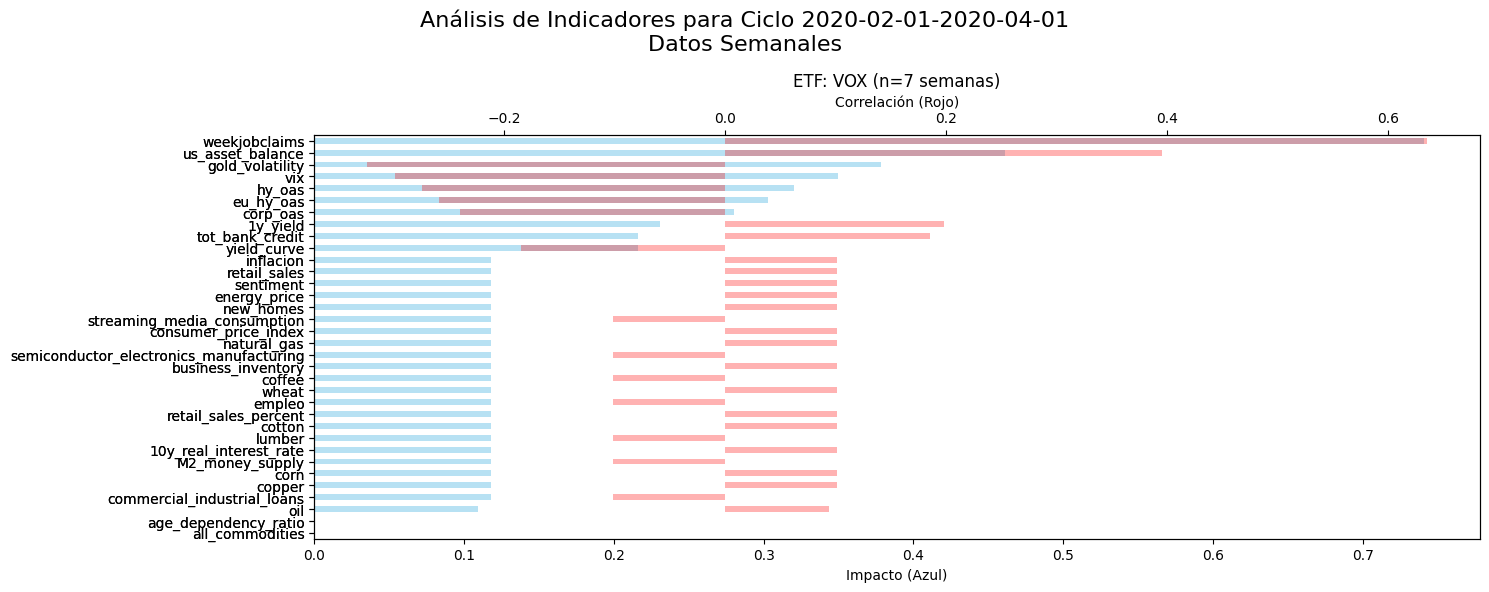

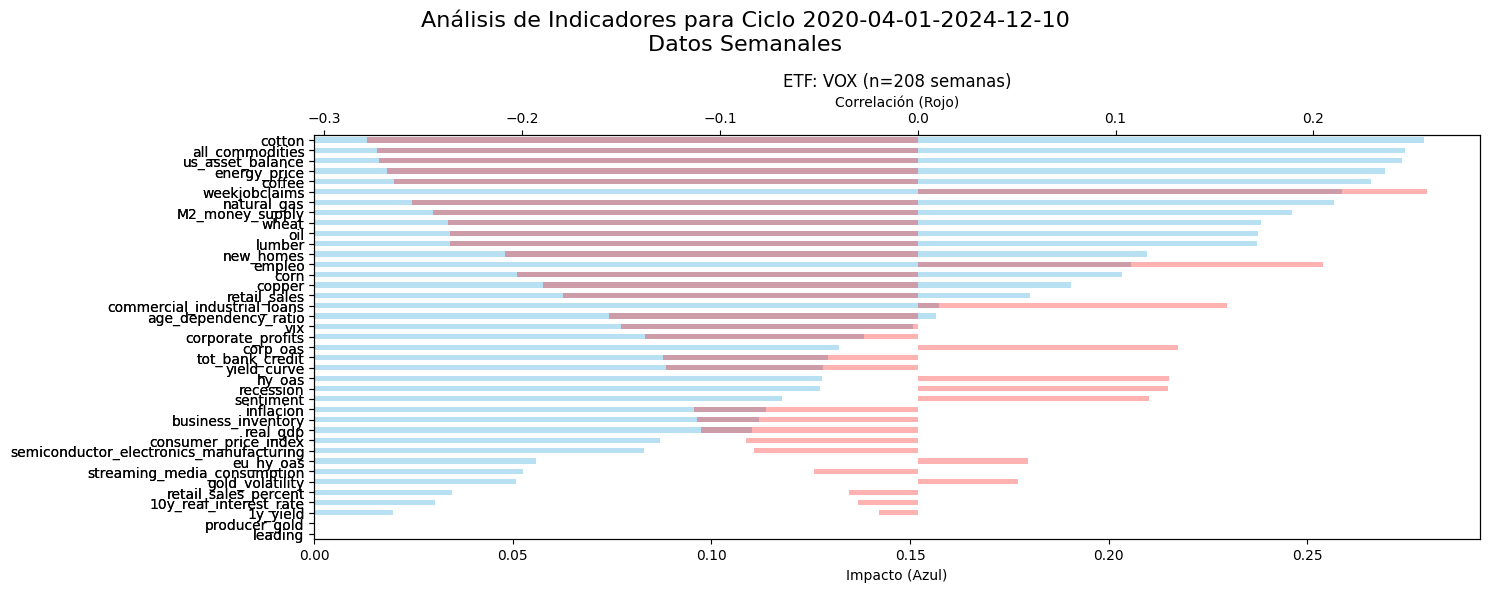

____________________________________________________________________________________________________


In [20]:
etfs = ["XLE", "XLB", "XLI", "XLK", "XLF",
            "XLP", "XLY", "XLV", "XLU", "IYR", "VOX"]

for etf in etfs:
    # Inicializar el analizador
    analyzer = SectorETFAnalyzer(etf)

    # Ejecutar análisis
    results = analyzer.run_analysis()

    # Generar y mostrar resumen
    summary = analyzer.generate_summary(results)
    print("\nResumen del análisis:")
    print(summary)

    # Generar gráficos para cada ciclo
    for cycle in results.keys():
        fig = analyzer.plot_cycle_results(
            results[cycle], 
            cycle,
            save_path=f'analisis_ciclo_{cycle.replace("/", "-")}.png'
        )
        plt.show()
        plt.close(fig)

    print("_"*100)

In [53]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import yfinance as yf
from pandas_datareader import data as pdr
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

class SectorETFAnalyzer2(SectorETFAnalyzer):
    def __init__(self, start_global='2000/01/01', end_global='2024/12/31'):
        """
        Inicializar el analizador con los ETFs e indicadores a analizar
        """
        super().__init__()
        self.etf_tickers = [
            "XLE", "XLB", "XLI", "XLK", "XLF",
            "XLP", "XLY", "XLV", "XLU", "IYR", "VOX"
        ]
        
        self.indicators = [
            'JHDUSRGDPBR', 'T10Y3M', 'BAMLC0A0CM', 'BAMLH0A0HYM2',
            'BAMLHE00EHYIOAS', 'UMCSENT', 'UNRATE', 'GDPC1', 'DCOILWTICO',
            'CORESTICKM159SFRBATL', 'USSLIND', 'VIXCLS', 'ICSA',
            'MARTSMPCSM44000USS', 'RSXFS', 'TREAST', 'DGS1'
        ]
        
        # Ciclos de crisis
        self.crisis_cycles = [
            ('2007/12/01', '2009/06/01'),
            ('2020/02/01', '2020/04/01')
        ]
        
        # Obtener todos los períodos incluyendo intermedios
        self.all_periods = self._get_all_periods(start_global, end_global)
        
    def _get_all_periods(self, start_global, end_global):
        """
        Genera todos los períodos a analizar, incluyendo intermedios
        """
        periods = []
        current_date = pd.to_datetime(start_global)
        
        # Agregar período inicial hasta primera crisis
        if current_date < pd.to_datetime(self.crisis_cycles[0][0]):
            periods.append((
                start_global,
                pd.to_datetime(self.crisis_cycles[0][0]).strftime('%Y/%m/%d')
            ))
        
        # Agregar períodos de crisis y períodos intermedios
        for i, (crisis_start, crisis_end) in enumerate(self.crisis_cycles):
            # Agregar período de crisis
            periods.append((crisis_start, crisis_end))
            
            # Agregar período intermedio si no es la última crisis
            if i < len(self.crisis_cycles) - 1:
                periods.append((
                    pd.to_datetime(crisis_end).strftime('%Y/%m/%d'),
                    pd.to_datetime(self.crisis_cycles[i+1][0]).strftime('%Y/%m/%d')
                ))
        
        # Agregar período final después de última crisis
        last_crisis_end = pd.to_datetime(self.crisis_cycles[-1][1])
        if last_crisis_end < pd.to_datetime(end_global):
            periods.append((
                last_crisis_end.strftime('%Y/%m/%d'),
                end_global
            ))
        
        return periods

    # [... resto de métodos anteriores sin cambios ...]

    def plot_etf_results(self, all_results, save_path=None):
        """
        Visualizar los resultados agrupados por ETF
        """
        for etf in self.etf_tickers:
            # Crear figura para este ETF
            fig, axes = plt.subplots(len(self.all_periods), 1, 
                                   figsize=(15, 6*len(self.all_periods)))
            fig.suptitle(f'Análisis de {etf} por Período', size=16)
            
            # Para cada período
            for idx, (start, end) in enumerate(self.all_periods):
                period_key = f"{start}-{end}"
                period_results = all_results[period_key][etf]
                
                # Identificar si es período de crisis
                is_crisis = (start, end) in self.crisis_cycles
                period_type = "Crisis" if is_crisis else "Normal"
                
                # Crear DataFrame para el período
                df_plot = pd.DataFrame({
                    'Impacto': pd.Series(period_results['impact_scores']),
                    'Correlación': pd.Series(period_results['correlations'])
                })
                
                # Ordenar por impacto
                df_plot = df_plot.sort_values('Impacto', ascending=True)
                
                # Determinar colores basados en si es período de crisis
                impact_color = 'red' if is_crisis else 'skyblue'
                corr_color = 'darkred' if is_crisis else 'blue'
                
                # Graficar
                ax = axes[idx] if len(self.all_periods) > 1 else axes
                df_plot['Impacto'].plot(kind='barh', ax=ax, 
                                      color=impact_color, alpha=0.6)
                ax2 = ax.twiny()
                df_plot['Correlación'].plot(kind='barh', ax=ax2, 
                                          color=corr_color, alpha=0.3)
                
                # Títulos y etiquetas
                period_dates = f"{start} a {end}"
                ax.set_title(f'Período {period_type}: {period_dates}\n'
                           f'(n={period_results["n_observations"]} semanas)')
                ax.set_xlabel('Impacto (Azul)')
                ax2.set_xlabel('Correlación (Rojo)')
            
            plt.tight_layout()
            
            if save_path:
                plt.savefig(f'{save_path}/analysis_{etf}.png')
            else:
                plt.show()
            
            plt.close(fig)
    
    def generate_summary_by_etf(self, all_results):
        """
        Generar resumen agrupado por ETF
        """
        summary_by_etf = {}
        
        for etf in self.etf_tickers:
            etf_summary = []
            
            for period_start, period_end in self.all_periods:
                period_key = f"{period_start}-{period_end}"
                period_results = all_results[period_key][etf]
                
                # Determinar tipo de período
                is_crisis = (period_start, period_end) in self.crisis_cycles
                period_type = "Crisis" if is_crisis else "Normal"
                
                # Encontrar indicadores top
                top_impact = max(period_results['impact_scores'].items(), 
                               key=lambda x: x[1])
                top_corr = max(period_results['correlations'].items(), 
                             key=lambda x: abs(x[1]))
                
                etf_summary.append({
                    'Período': f"{period_start} a {period_end}",
                    'Tipo': period_type,
                    'Top_Indicator_Impact': top_impact[0],
                    'Impact_Score': top_impact[1],
                    'Top_Indicator_Corr': top_corr[0],
                    'Correlation': top_corr[1],
                    'N_Weeks': period_results['n_observations']
                })
            
            summary_by_etf[etf] = pd.DataFrame(etf_summary)
        
        return summary_by_etf

# Ejemplo de uso:
"""
# Inicializar el analizador
analyzer = SectorETFAnalyzer(start_global='2000/01/01', end_global='2024/12/31')

# Ejecutar análisis
results = analyzer.run_analysis()

# Generar resumen por ETF
summary_by_etf = analyzer.generate_summary_by_etf(results)

# Mostrar resumen para cada ETF
for etf, summary in summary_by_etf.items():
    print(f"\nResumen para {etf}:")
    print(summary)

# Generar visualizaciones por ETF
analyzer.plot_etf_results(results, save_path='resultados')
"""

'\n# Inicializar el analizador\nanalyzer = SectorETFAnalyzer(start_global=\'2000/01/01\', end_global=\'2024/12/31\')\n\n# Ejecutar análisis\nresults = analyzer.run_analysis()\n\n# Generar resumen por ETF\nsummary_by_etf = analyzer.generate_summary_by_etf(results)\n\n# Mostrar resumen para cada ETF\nfor etf, summary in summary_by_etf.items():\n    print(f"\nResumen para {etf}:")\n    print(summary)\n\n# Generar visualizaciones por ETF\nanalyzer.plot_etf_results(results, save_path=\'resultados\')\n'

In [54]:
# Inicializar el analizador
analyzer = SectorETFAnalyzer2(start_global='2000/01/01', end_global='2024/12/31')

# Ejecutar análisis
results = analyzer.run_analysis()

# Generar resumen por ETF
summary_by_etf = analyzer.generate_summary_by_etf(results)

# Mostrar resumen para cada ETF
for etf, summary in summary_by_etf.items():
    print(f"\nResumen para {etf}:")
    print(summary)

# Generar visualizaciones por ETF
analyzer.plot_etf_results(results, save_path='resultados')

TypeError: SectorETFAnalyzer.__init__() missing 1 required positional argument: 'etf'